# Uncovering Healthcare Inefficiencies - EDA and Data Preprocesssing 

This notebook focuses on exploring and preprocessing the Market Saturation and Utilization Data from the Centers for Medicare & Medicaid Services (CMS). The dataset, obtained via the CMS API, provides valuable insights into Medicare Fee-for-Service (FFS) claims, facilitating the analysis of market saturation and healthcare service utilization across states and counties.

---

## Table of Contents

1. [Import Libraries](#import-libraries)
2. [Import Data](#import-data)
3. [Exploratory Data Analysis](#exploratory-data-analysis)
4. [Visualizations](#visualizations)
5. [Feature Selection](#feature-selection)
6. [Train, Test, and Validation Split](#train-test-and-validation-split)

<div id='import-libraries'/>

## Import Libraries

The following libraries are imported to support the exploratory data analysis and data retrieval process:

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from tqdm import tqdm

from tabulate import tabulate

from scipy import stats
from scipy.stats import chi2_contingency

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # supress warning 

<div id='import-data'/>

## Import Data

Import data previously retrieved in the `Data-retrieval.ipynb` notebook stored in a csv file. 

The dataset is large, with over a million rows, the `low_memory=False` option in pandas.read_csv is used to avoid mixed data type warnings and ensure efficient reading.

In [2]:
# Read in data - might take a while because there 1m+ rows
data = pd.read_csv('data/cms_data.csv', low_memory=False) # use 'low_memory=False' to isntruct Pandas to use more memorry and avoid mixed data types 

In [3]:
data.head()

,reference_period,type_of_service,aggregation_level,state,county,state_fips,county_fips,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,...,number_of_fee_for_service_beneficiaries_change,number_of_providers_change,average_number_of_users_per_provider_change,percentage_of_users_out_of_ffs_beneficiaries_change,number_of_users_change,average_number_of_providers_per_county_change,number_of_dual_eligible_users_change,percentage_of_dual_eligible_users_out_of_total_users_change,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_change,total_payment_change
0,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),NATION + TERRITORIES,--ALL--,--ALL--,,,"36,122,263","8,814",495.69,...,5.81%,0.34%,1.28%,( 3.97%),1.62%,1.19%,( 4.89%),( 6.43%),( 1.20%),1.80%
1,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),STATE,AL,--ALL--,01,,"547,486",146,501.47,...,3.53%,( 2.01%),0.86%,( 4.57%),( 1.17%),1.82%,(11.81%),(10.78%),( 1.35%),( 2.76%)
2,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),STATE,AK,--ALL--,02,,"91,480",33,254.97,...,38.93%,3.13%,19.77%,(11.11%),23.52%,0.15%,0.67%,(18.50%),0.27%,21.32%
3,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),STATE,AZ,--ALL--,04,,"740,278",170,401.34,...,8.98%,( 3.41%),6.63%,( 5.44%),3.00%,( 5.90%),( 1.55%),( 4.38%),( 6.60%),7.07%
4,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),STATE,AR,--ALL--,05,,"437,616",86,628.07,...,3.79%,( 3.37%),5.17%,( 2.14%),1.62%,( 7.84%),,,,3.64%


<div id='exploratory-data-analysis'/>
    
## Exploratory Data Analysis

In [4]:
# Check the unique values in the problematic column to understand the data type issue
print(data.iloc[:, 12].unique())

['39.85' '12.3' '6.61' ... '48.17' '17.15' '107.22']


After using the unique command, it shows that there are strings and floats in the column. To fix that, all the cells in that column are converted to numeric.

A user defined function is created to check for commas, percent signs, parenthesis, and whitespace. If the cell within a column has that, then it removes it.

### Removing Whitespace and Special Characters 

To clean the data, a function is created to remove unnecessary characters such as commas, percentages, parentheses, and extra whitespace. The function is applied to all relevant columns starting from the 7th column, which typically contains numerical data that might have these special characters.

In [5]:
# Function to remove ',', '%', '()', and whitespace characters from values
def remove_special_characters(value):
    if isinstance(value, str):
        value = value.replace('%', '')
        value = value.replace('(', '')
        value = value.replace(')', '')
        value = value.replace(',', '')
        value = value.strip()  
    return value

# Determine columns to apply the function on (starting from index 7)
start_index = 7
columns_to_check = data.columns[start_index:]

# Apply remove_special_characters function to each column
for col in columns_to_check:
    data[col] = data[col].apply(remove_special_characters)

### Checking Unique Values (Categorical Variables)
A summary of unique values is generated for the first few columns, which are likely categorical, to understand the diversity and distribution of these values. This helps in identifying any anomalies or potential data entry issues.

In [6]:
# Function to create a table of unique values for each column with the count
def unique_values_summary(df):
    summary = pd.DataFrame(columns=['Column', 'Unique Values', 'Count'])
    for col in df.columns:
        unique_values = df[col].unique()
        count = len(unique_values)
        unique_values_str = ', '.join(map(str, unique_values[:5]))  # Convert unique values to a string, showing only first 5
        summary = pd.concat([summary, pd.DataFrame({'Column': [col], 'Unique Values': [unique_values_str], 'Count': [count]})], ignore_index=True)
    return summary

# Get unique values summary for the first 7 columns
summary = unique_values_summary(data.iloc[:, :7]) 

# Convert DataFrame to tabular format using tabulate
tabulated_summary = tabulate(summary, headers='keys', tablefmt='fancy_grid')

# Print the tabulated summary
print(tabulated_summary)

╒════╤═══════════════════╤════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤═════════╕
│    │ Column            │ Unique Values                                                                                                                                  │   Count │
╞════╪═══════════════════╪════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╪═════════╡
│  0 │ reference_period  │ 2019-01-01 to 2019-12-31, 2019-04-01 to 2020-03-31, 2019-07-01 to 2020-06-30, 2019-10-01 to 2020-09-30, 2020-01-01 to 2020-12-31               │      17 │
├────┼───────────────────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼─────────┤
│  1 │ type_of_service   │ Ambulance (Emergency & Non-Emergency), Ambulance (Emergency), A

### Convert Data Types - String Types into Numeric

Since many columns that should be numeric are read as strings due to the presence of special characters, the columns are converted to their appropriate numeric types. This ensures that numerical operations and analyses can be performed correctly.

In [7]:
# Function to convert string numbers to floats
def convert_to_float(value):
    try:
        return float(value)
    except ValueError:
        return value  # Return as-is if conversion fails

# Apply the function to the column
data['average_number_of_providers_per_county'] = data['average_number_of_providers_per_county'].apply(convert_to_float)

# Verify the data types and values
print("Data types after conversion:")
print(data['average_number_of_providers_per_county'].apply(type).unique())  # Check unique data types

Data types after conversion:
[<class 'float'>]


### Summarize Column Types 
Summarize the column types to ensure that the data types are as expected after the conversions. This step helps in verifying that all numerical data is in the correct format and ready for further analysis.

In [8]:
# Function to summarize column types
def column_types_summary(df):
    types_summary = []
    for col in df.columns:
        column_type = type(df[col].dropna().iloc[0])
        types_summary.append({'Column': col, 'Type': column_type.__name__})
    return pd.DataFrame(types_summary)

# Get column types summary
types_summary = column_types_summary(data.iloc[:, 7:])

# Convert types summary to tabular format using tabulate
tabulated_summary = tabulate(types_summary, headers='keys', tablefmt='fancy_grid')

# Print the tabulated summary
print(tabulated_summary)

╒════╤══════════════════════════════════════════════════════════════════════════════════════╤═════════╕
│    │ Column                                                                               │ Type    │
╞════╪══════════════════════════════════════════════════════════════════════════════════════╪═════════╡
│  0 │ number_of_fee_for_service_beneficiaries                                              │ str     │
├────┼──────────────────────────────────────────────────────────────────────────────────────┼─────────┤
│  1 │ number_of_providers                                                                  │ str     │
├────┼──────────────────────────────────────────────────────────────────────────────────────┼─────────┤
│  2 │ average_number_of_users_per_provider                                                 │ str     │
├────┼──────────────────────────────────────────────────────────────────────────────────────┼─────────┤
│  3 │ percentage_of_users_out_of_ffs_beneficiaries             

Just checking the first column that is a Str Type, it is evident that there are empty spots but it didn't show up in the missing values table above.
### Unique Values 
To gain deeper insights into the unique values of various features in the dataset, a summary of unique values across columns was generated. This helps in understanding the distribution and variety of data present in each column, which is crucial for subsequent analysis and preprocessing.

In [9]:
# Get unique values summary for the rest of the dataframe
summary = unique_values_summary(data.iloc[:, 7:]) 

# Convert DataFrame to tabular format using tabulate
tabulated_summary = tabulate(summary, headers='keys', tablefmt='fancy_grid')

# Print the tabulated summary
print(tabulated_summary)

╒════╤══════════════════════════════════════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤═════════╕
│    │ Column                                                                               │ Unique Values                                                                                                                                                                             │   Count │
╞════╪══════════════════════════════════════════════════════════════════════════════════════╪═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╪═════════╡
│  0 │ number_of_fee_for_service_beneficiaries                                              │ 36122263, 547486, 91480, 74027

### Converting Columns to Float

Columns previously identified starting from index 7 to 16 and 38 to 47 are converted to float. 

The unique values summary indicates that certain columns do not contain missing values and are numeric in nature, including columns 7-16 and 38-47. The next step involves converting these columns to numeric data types for consistency and easier manipulation.

#### Conversion of `total_paymnet`
The following code removes the dollar signs from the total_payment column and converts it to a float type for easier manipulation:

In [10]:
data['total_payment'] = data['total_payment'].str.replace('$','').astype(float)

Earlier, only  `average_number_of_providers_per_county to numeric` was converted - remianing columns will be converted. 

In [11]:
# Function to apply conversion to columns starting from a specific index in a DataFrame
def convert_columns_to_float_from_index(df, start_index, end_index):
    # Ensure the end_index is within the bounds of the DataFrame columns
    end_index = min(end_index, len(df.columns) - 1)
    
    for idx in range(start_index, end_index + 1):
        df.iloc[:, idx] = pd.to_numeric(df.iloc[:, idx], errors='coerce')
        df.iloc[:, idx] = df.iloc[:, idx].astype(float)
    return df

# Convert columns starting from specified index to float
data = convert_columns_to_float_from_index(data, 7, 16)
data = convert_columns_to_float_from_index(data, 38, 47)

# numeric columns only
num_feat_names = data.iloc[: , 7:16].columns.append(data.iloc[:, 38:48].columns)
for name in num_feat_names:
    data[name] = data[name].astype(float)


# non-numeric columns only
cat_feat_names = data.iloc[: , :8].columns.append(data.iloc[:, 17:38].columns)

Checking the types for each column again after conversion - should just be float64.

#### Checking Data Types After Conversion

##### Get Column Types Summary

This step ensures that the focus is steered on the relevant columns for which data types are to be reviewed. 

In [12]:
# Get column types summary
types_summary = column_types_summary(data.iloc[:, 7:])

# Convert types summary to tabular format using tabulate
tabulated_summary = tabulate(types_summary, headers='keys', tablefmt='fancy_grid')

# Print the tabulated summary
print(tabulated_summary)

╒════╤══════════════════════════════════════════════════════════════════════════════════════╤═════════╕
│    │ Column                                                                               │ Type    │
╞════╪══════════════════════════════════════════════════════════════════════════════════════╪═════════╡
│  0 │ number_of_fee_for_service_beneficiaries                                              │ float64 │
├────┼──────────────────────────────────────────────────────────────────────────────────────┼─────────┤
│  1 │ number_of_providers                                                                  │ float64 │
├────┼──────────────────────────────────────────────────────────────────────────────────────┼─────────┤
│  2 │ average_number_of_users_per_provider                                                 │ float64 │
├────┼──────────────────────────────────────────────────────────────────────────────────────┼─────────┤
│  3 │ percentage_of_users_out_of_ffs_beneficiaries             

### Check for Missing Values

#### Count Missing Values 
This part of the code calculates the number of missing values (NaNs) for each column in the data.  

The total number of records (rows) are computed and used to determine the percentage of missing values for each column. This percentage calculation helps identify columns with significant amounts of missing data.

The `na_counts_df` DataFrame is filtered to identify columns where the percentage of missing values exceeds 50%. This threshold helps in focusing on columns that may require more attention or potential cleaning.

In [13]:
# Count how many missing values (NaNs) there are for each column
na_counts = data.isna().sum()
total_records = len(data)
percentage_na = (na_counts / total_records) * 100  # Percentage calculation

# Generate DataFrame from the counts and percentages
na_counts_df = pd.DataFrame({'Missing Count': na_counts, 'Percentage': percentage_na})

# Reset index & rename the index column
na_counts_df.reset_index(inplace=True)
na_counts_df.rename(columns={'index': 'Column'}, inplace=True)

# Print the original DataFrame with counts of NaN values
print("DataFrame with counts of NaN values:")
print(tabulate(na_counts_df, headers='keys', tablefmt='fancy_grid'))

# Filter columns with more than 50% missing data
threshold = 50
columns_above_threshold = na_counts_df[na_counts_df['Percentage'] > threshold]

# Print columns with more than 50% missing data
print("\nColumns with more than 50% missing data:")
print(tabulate(columns_above_threshold, headers='keys', tablefmt='fancy_grid'))

DataFrame with counts of NaN values:
╒════╤══════════════════════════════════════════════════════════════════════════════════════╤═════════════════╤══════════════╕
│    │ Column                                                                               │   Missing Count │   Percentage │
╞════╪══════════════════════════════════════════════════════════════════════════════════════╪═════════════════╪══════════════╡
│  0 │ reference_period                                                                     │               0 │      0       │
├────┼──────────────────────────────────────────────────────────────────────────────────────┼─────────────────┼──────────────┤
│  1 │ type_of_service                                                                      │               0 │      0       │
├────┼──────────────────────────────────────────────────────────────────────────────────────┼─────────────────┼──────────────┤
│  2 │ aggregation_level                                                  

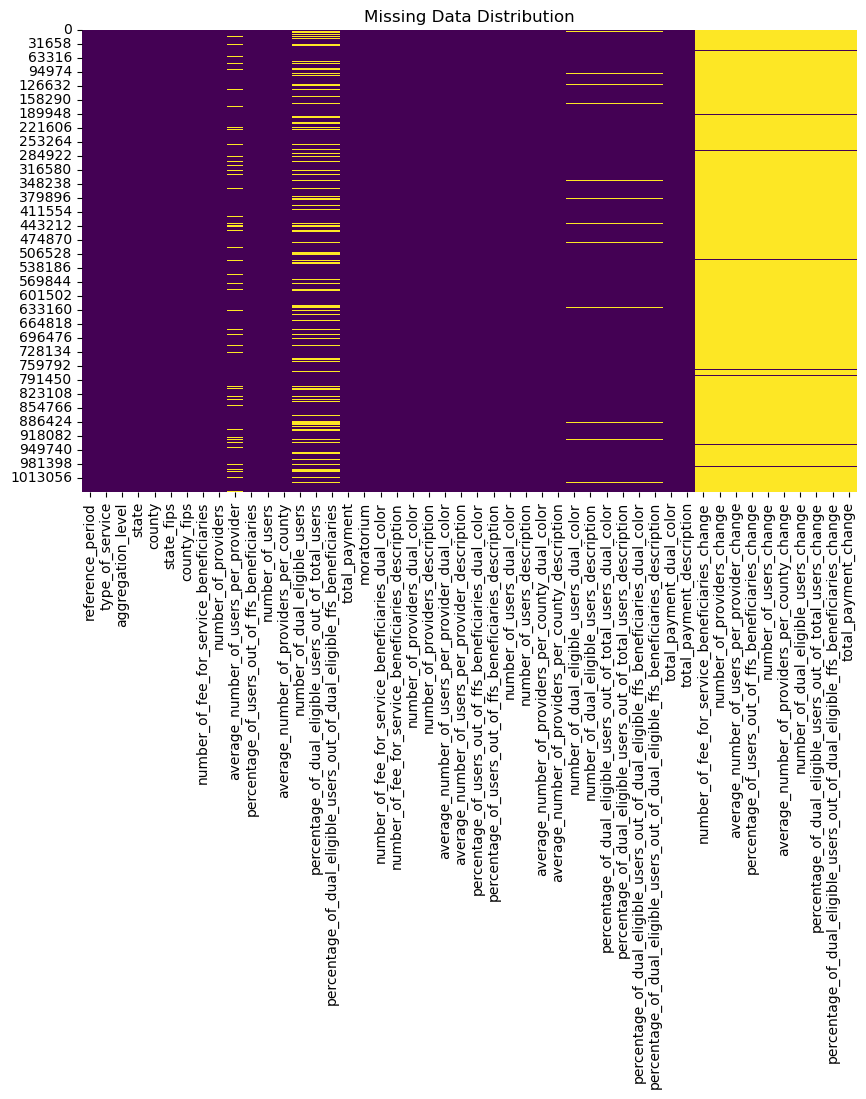

In [14]:
# plot misisng data distribution 
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Distribution')
plt.show()

Areas highlighted in yellow exhibit high levels of missing data, generally above 50%, indicating critical areas that need attention as they may significantly impact modeling. Areas shown in purple do not have any missing data, suggesting that the columns are relatively complete, yet they still require some level of scrutiny depending on the extent and impact of the missing values.

To address these issues, it will determine whether the mising values will be imputed or removed by assesing their impact. 

There are numerous columns with significant missing values, which might indicate that users left these fields blank instead of entering zeros. To handle this, missing values are imputed with zeros.

The kurtosis of the numeric columns are compared before and after imputation with zeros.

##### **Before Imputation**

In [15]:
# before imputation 
# exclude non-numeric columns
numeric_data = data.select_dtypes(include=['float', 'int'])

# kurtosis of variables before imputting
print('Kurtosis Before Replacing Missing Values with Zeros:')
numeric_data.kurtosis()

Kurtosis Before Replacing Missing Values with Zeros:


number_of_fee_for_service_beneficiaries                                             2745.319181
number_of_providers                                                                23792.802195
average_number_of_users_per_provider                                                 287.086006
percentage_of_users_out_of_ffs_beneficiaries                                           1.837552
number_of_users                                                                    13090.892832
average_number_of_providers_per_county                                               566.870967
number_of_dual_eligible_users                                                       8858.256024
percentage_of_dual_eligible_users_out_of_total_users                                   0.976728
percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries               1.243945
total_payment                                                                      25831.008965
number_of_fee_for_service_beneficiaries_

In [16]:
# fill in missing values with 0's
na_df = data.copy() #create a copy of the df 
na_df.iloc[:, 38:48] = na_df.iloc[:,38:48].fillna(0)

##### **After Imputation**

In [17]:
# after imputation
# exclude non-numeric columns
na_numeric_data = na_df.select_dtypes(include=['float', 'int'])

# kurtosis of variables after imputting
print('Kurtosis after Replacing Missing Values with Zeros')
na_numeric_data.kurtosis()

Kurtosis after Replacing Missing Values with Zeros


number_of_fee_for_service_beneficiaries                                              2745.319181
number_of_providers                                                                 23792.802195
average_number_of_users_per_provider                                                  287.086006
percentage_of_users_out_of_ffs_beneficiaries                                            1.837552
number_of_users                                                                     13090.892832
average_number_of_providers_per_county                                                566.870967
number_of_dual_eligible_users                                                        8858.256024
percentage_of_dual_eligible_users_out_of_total_users                                    0.976728
percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries                1.243945
total_payment                                                                       25831.008965
number_of_fee_for_service_bene

The comparison reveals that filling missing values with zeros significantly alters the kurtosis of the data features. This suggests that using zeros for imputation might not be the most suitable approach. Further investigation into more appropriate imputation methods or decisions to drop variables with excessive missing data may be necessary to maintain the quality and reliability of the analysis.

#### Relationships Between Features
##### **Numeric Features Correlation Analysis**

##### *Correlation Matrix Before Replacing Missing Values with Zeros:*
Correlation analysis is performed on numeric values before and after replacing missing values with zeros. The correlation matrix before imputation is displayed below.

In [18]:
# perform correlation analysiss on numeric values 
original_corr = numeric_data.corr()
original_corr

,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,number_of_users,average_number_of_providers_per_county,number_of_dual_eligible_users,percentage_of_dual_eligible_users_out_of_total_users,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries,total_payment,number_of_fee_for_service_beneficiaries_change,number_of_providers_change,average_number_of_users_per_provider_change,percentage_of_users_out_of_ffs_beneficiaries_change,number_of_users_change,average_number_of_providers_per_county_change,number_of_dual_eligible_users_change,percentage_of_dual_eligible_users_out_of_total_users_change,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_change,total_payment_change
number_of_fee_for_service_beneficiaries,1.000000,0.513845,0.155145,0.000219,0.649375,0.062690,0.704795,-0.002298,-0.006453,0.497340,-0.031686,0.000023,-0.054474,-0.002962,-0.003272,0.002358,-0.004200,-0.042738,-0.003623,-0.004181
number_of_providers,0.513845,1.000000,0.010119,0.038329,0.704349,0.157883,0.637648,-0.018676,0.029946,0.103567,-0.020485,0.003843,-0.053660,0.000994,0.000161,0.004570,0.000032,-0.004366,0.000457,0.000157
average_number_of_users_per_provider,0.155145,0.010119,1.000000,0.233266,0.246165,0.006783,0.265996,-0.050299,0.267447,0.204741,-0.042449,-0.026557,-0.031100,-0.027672,-0.020947,-0.023990,-0.024831,-0.017866,-0.026498,-0.022904
percentage_of_users_out_of_ffs_beneficiaries,0.000219,0.038329,0.233266,1.000000,0.042516,0.276058,0.034229,-0.353973,0.943601,0.012474,-0.062967,-0.018307,-0.187509,-0.019035,-0.013405,-0.016979,-0.017955,0.012969,-0.019688,-0.013588
number_of_users,0.649375,0.704349,0.246165,0.042516,1.000000,0.098247,0.965852,-0.015108,0.039584,0.485997,-0.023925,-0.004607,-0.058637,-0.005778,-0.004662,-0.003315,-0.005798,-0.016224,-0.005864,-0.005082
average_number_of_providers_per_county,0.062690,0.157883,0.006783,0.276058,0.098247,1.000000,0.100660,-0.126048,0.224228,0.017387,-0.057415,0.016366,-0.136964,0.014203,0.009888,0.017891,0.010969,-0.030366,0.012857,0.012724
number_of_dual_eligible_users,0.704795,0.637648,0.265996,0.034229,0.965852,0.100660,1.000000,0.000184,0.037998,0.511635,-0.024591,-0.001495,-0.062250,-0.003357,-0.003168,0.000489,-0.003675,-0.035948,-0.003485,-0.003512
percentage_of_dual_eligible_users_out_of_total_users,-0.002298,-0.018676,-0.050299,-0.353973,-0.015108,-0.126048,0.000184,1.000000,-0.205008,-0.000955,0.064712,0.024949,0.088446,0.035182,0.022234,0.030057,0.041047,-0.252289,0.042523,0.021934
percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries,-0.006453,0.029946,0.267447,0.943601,0.039584,0.224228,0.037998,-0.205008,1.000000,0.011488,-0.058329,-0.008534,-0.189580,-0.012623,-0.008829,-0.008513,-0.012208,-0.031618,-0.014228,-0.007185
total_payment,0.497340,0.103567,0.204741,0.012474,0.485997,0.017387,0.511635,-0.000955,0.011488,1.000000,-0.018106,-0.007393,-0.032732,-0.007161,-0.005525,-0.006361,-0.007146,-0.035301,-0.006703,-0.006270


Text(0.5, 1.0, 'Upper Triangular Correlation Matrix before Replacing Missing Values with Zeros')

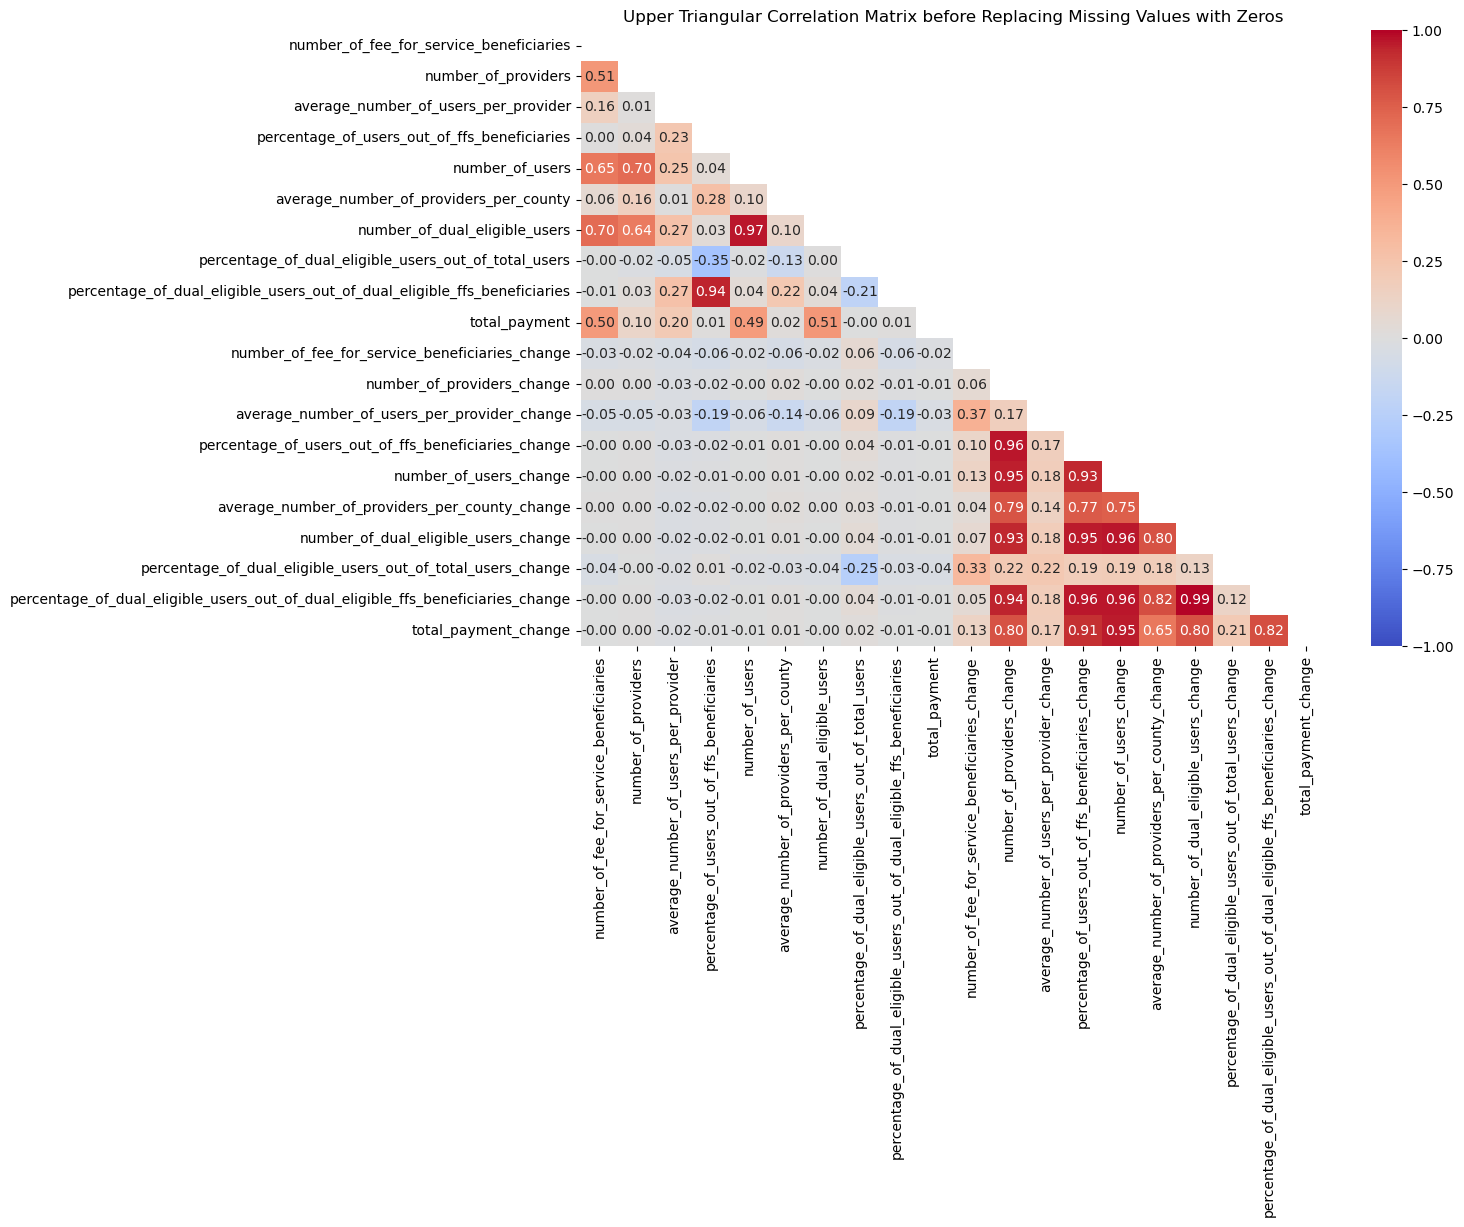

In [19]:
# create a mask for the upper triangle
mask = np.triu(np.ones_like(original_corr, dtype=bool))

# plot the upper triangular correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(original_corr, annot=True, cmap='coolwarm', fmt=".2f", mask=mask, vmin=-1, vmax=1)
plt.title('Upper Triangular Correlation Matrix before Replacing Missing Values with Zeros')

##### *Correlation Matrix After Replacing Missing Values with Zeros:*

In [20]:
# perform correlation analysis on numeric values (after imputation)
na_corr = na_numeric_data.corr()
na_corr

,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,number_of_users,average_number_of_providers_per_county,number_of_dual_eligible_users,percentage_of_dual_eligible_users_out_of_total_users,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries,total_payment,number_of_fee_for_service_beneficiaries_change,number_of_providers_change,average_number_of_users_per_provider_change,percentage_of_users_out_of_ffs_beneficiaries_change,number_of_users_change,average_number_of_providers_per_county_change,number_of_dual_eligible_users_change,percentage_of_dual_eligible_users_out_of_total_users_change,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_change,total_payment_change
number_of_fee_for_service_beneficiaries,1.000000,0.513845,0.155145,0.000219,0.649375,0.062690,0.704795,-0.002298,-0.006453,0.497340,0.120190,0.015101,0.113723,0.012825,0.008742,0.014924,0.015551,0.173432,0.012664,0.010725
number_of_providers,0.513845,1.000000,0.010119,0.038329,0.704349,0.157883,0.637648,-0.018676,0.029946,0.103567,0.060429,0.011557,0.041343,0.009109,0.006319,0.011045,0.010254,0.101813,0.008845,0.007791
average_number_of_users_per_provider,0.155145,0.010119,1.000000,0.233266,0.246165,0.006783,0.265996,-0.050299,0.267447,0.204741,0.153897,0.000935,0.161863,0.000646,0.000412,-0.000066,0.006703,0.219746,0.001734,0.002438
percentage_of_users_out_of_ffs_beneficiaries,0.000219,0.038329,0.233266,1.000000,0.042516,0.276058,0.034229,-0.353973,0.943601,0.012474,-0.009406,-0.002656,-0.021967,-0.002765,-0.001964,-0.002443,-0.002625,-0.002381,-0.002790,-0.002040
number_of_users,0.649375,0.704349,0.246165,0.042516,1.000000,0.098247,0.965852,-0.015108,0.039584,0.485997,0.074444,0.005565,0.055988,0.004738,0.003288,0.005286,0.007179,0.117419,0.004932,0.004703
average_number_of_providers_per_county,0.062690,0.157883,0.006783,0.276058,0.098247,1.000000,0.100660,-0.126048,0.224228,0.017387,0.036811,0.009537,0.023532,0.009086,0.006631,0.009176,0.009576,0.063165,0.008904,0.008341
number_of_dual_eligible_users,0.704795,0.637648,0.265996,0.034229,0.965852,0.100660,1.000000,0.000184,0.037998,0.511635,0.094048,0.009231,0.064728,0.007777,0.005278,0.009473,0.010074,0.117124,0.007879,0.006898
percentage_of_dual_eligible_users_out_of_total_users,-0.002298,-0.018676,-0.050299,-0.353973,-0.015108,-0.126048,0.000184,1.000000,-0.205008,-0.000955,-0.007694,0.001924,-0.004926,0.003248,0.001887,0.002799,0.003681,-0.037679,0.004183,0.001599
percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries,-0.006453,0.029946,0.267447,0.943601,0.039584,0.224228,0.037998,-0.205008,1.000000,0.011488,-0.024050,-0.002883,-0.037850,-0.003492,-0.002537,-0.002630,-0.003840,-0.024604,-0.003743,-0.002619
total_payment,0.497340,0.103567,0.204741,0.012474,0.485997,0.017387,0.511635,-0.000955,0.011488,1.000000,0.056807,0.000776,0.051151,0.001155,0.000749,0.000601,0.003048,0.077042,0.001776,0.001448


Text(0.5, 1.0, 'Upper Triangular Correlation Matrix after Replacing Missing Values with Zeros')

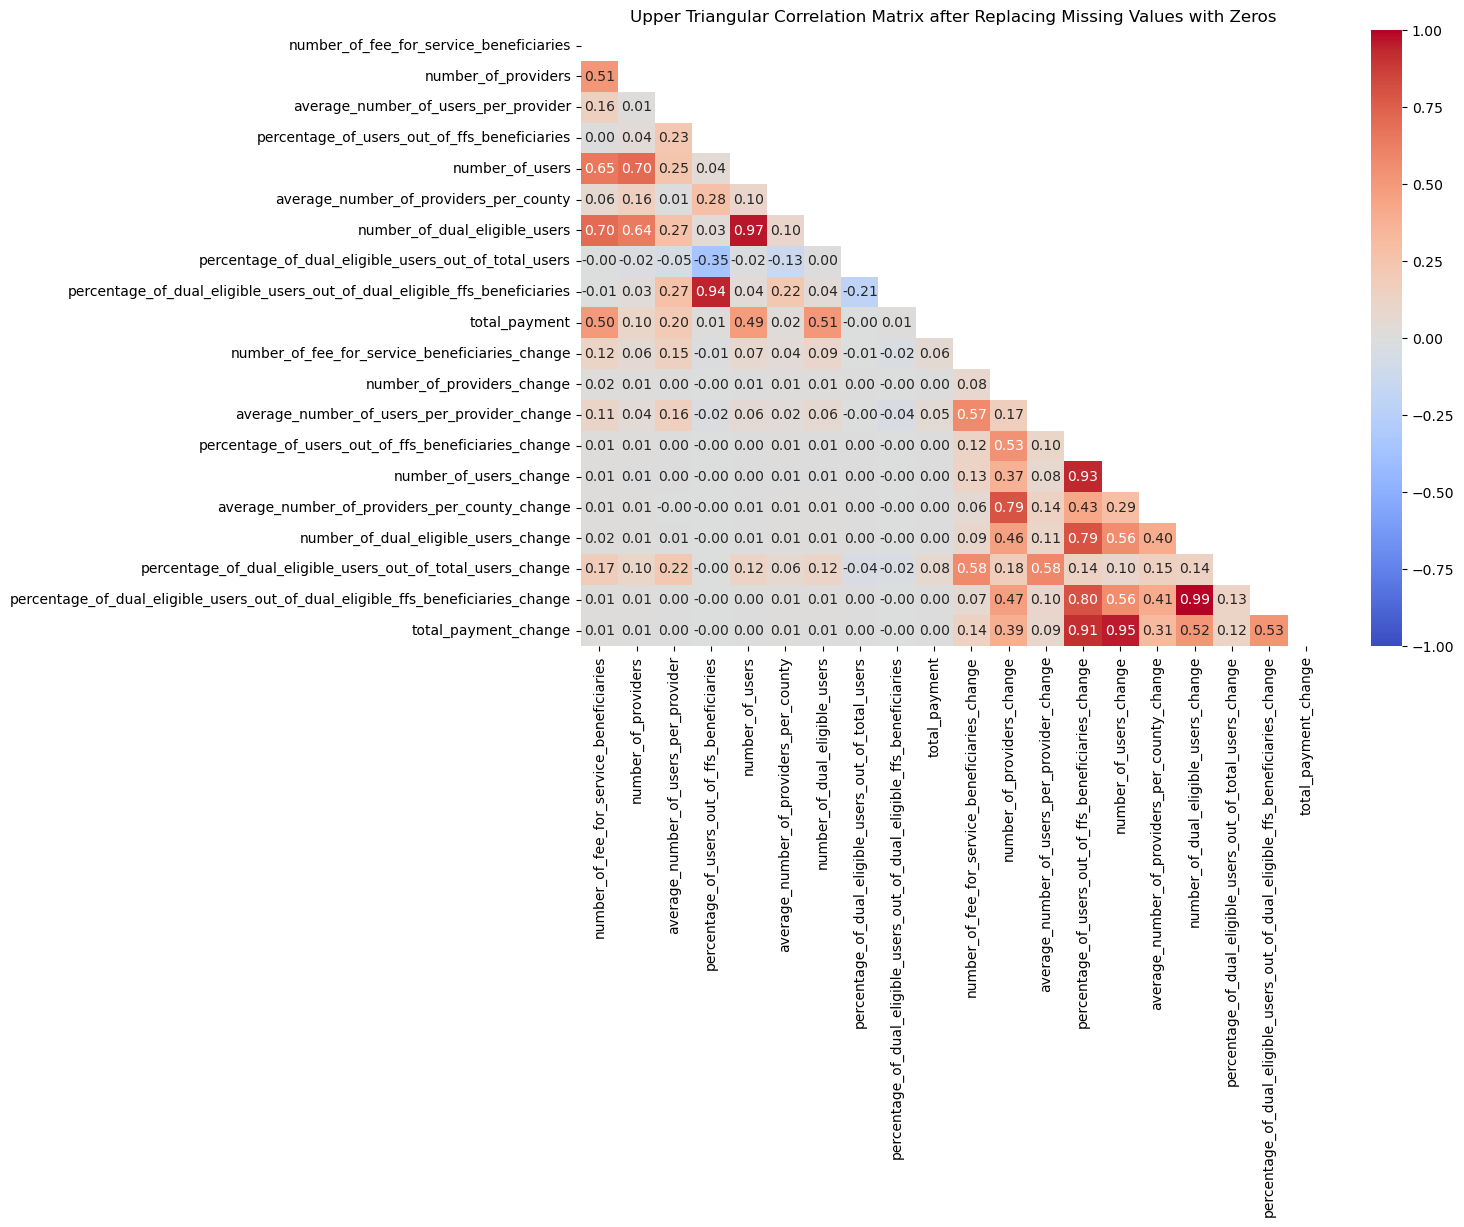

In [21]:
# create a mask for the upper triangle
mask = np.triu(np.ones_like(na_corr, dtype=bool))

# plot the upper triangular correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(na_corr, annot=True, cmap='coolwarm', fmt=".2f", mask=mask, vmin=-1, vmax=1)
plt.title('Upper Triangular Correlation Matrix after Replacing Missing Values with Zeros')

Based on the relationship between features before and after imputation, it can be concluded that introducing zeros for missing values could distort these relationships and lead to incorrect conclusions. Thus, columns with over 50% missing data will be dropped, and the remaining missing values will be imputed. 

Columns with high correlations and redundant description columns will be removed to simplify the dataset and avoid multicollinearity issues. The updated dataset will then be used to perform a more accurate correlation analysis and ensure the integrity of the insights drawn from the data.

#### Handling Missing Values 

Through observations, it was found that introducing zeros as a replacement for missing values can distort the relationships between variables and lead to inaccurate insights. To mitigate this risk, columns with more than 50% missing data are identified and removed. 

In [22]:
# drop columns that are missing 50% or more data 
# Calculate percentage of missing values for each column
missing_percentages = (data.isnull().sum() / len(data)) * 100

# Create a boolean mask for columns with more than 50% missing data
columns_to_drop = missing_percentages[missing_percentages > 50].index

# Drop columns from the DataFrame without inplace=True
data = data.drop(columns=columns_to_drop)

data.head()

,reference_period,type_of_service,aggregation_level,state,county,state_fips,county_fips,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,...,average_number_of_providers_per_county_dual_color,average_number_of_providers_per_county_description,number_of_dual_eligible_users_dual_color,number_of_dual_eligible_users_description,percentage_of_dual_eligible_users_out_of_total_users_dual_color,percentage_of_dual_eligible_users_out_of_total_users_description,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_description,total_payment_dual_color,total_payment_description
0,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),NATION + TERRITORIES,--ALL--,--ALL--,,,36122263.0,8814.0,495.69,...,,,,,,,,,,
1,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),STATE,AL,--ALL--,01,,547486.0,146.0,501.47,...,BLUE 2,Second Lowest 25 7.10 - 15.11 Providers,BLUE 3,Third Lowest 25 14276 - 31537 Dual Eligible Users,BLUE 4,Top 25 Excl. Extreme Values 33.61 - 49.85 of T...,BLUE 3,Third Lowest 25 19.99 - 22.03 of Total FFS Ben...,BLUE 3,Third Lowest 25 $49345636.69 - $106424718.18
2,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),STATE,AK,--ALL--,02,,91480.0,33.0,254.97,...,BLUE 1,Lowest 25 Less than 7.10 Providers,BLUE 1,Lowest 25 Less than 4833 Dual Eligible Users,BLUE 4,Top 25 Excl. Extreme Values 33.61 - 49.85 of T...,BLUE 2,Second Lowest 25 17.37 - 19.98 of Total FFS Be...,BLUE 1,Lowest 25 Less than $13090494.20
3,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),STATE,AZ,--ALL--,04,,740278.0,170.0,401.34,...,BLUE 4,Top 25 Excl. Extreme Values 37.53 - 83.16 Prov...,BLUE 2,Second Lowest 25 4833 - 14275 Dual Eligible Users,BLUE 1,Lowest 25 Less than 22.78 of Total Users,BLUE 1,Lowest 25 Less than 17.37 of Total FFS Benefic...,BLUE 2,Second Lowest 25 $13090494.20 - $49345636.68
4,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),STATE,AR,--ALL--,05,,437616.0,86.0,628.07,...,BLUE 2,Second Lowest 25 7.10 - 15.11 Providers,NaN,NaN,NaN,NaN,NaN,NaN,BLUE 3,Third Lowest 25 $49345636.69 - $106424718.18


Subsequently, the first row with a significant missing values is also removed to maintain data quality.

In [23]:
# first row appears to be a missing a majority of its values -  remove row instead of replacing for data integrity 
data.drop(data.index[0], inplace=True)

To handle the remaining missing values, the code imputes them using the mode for each column. This approach ensures that the imputed values are representative of the existing data distribution.

In [24]:
# Count how many missing values are remaining (NaNs) for each column (should be columns with less than 50% misisng data)
na_counts = data.isna().sum()
total_records = len(data)
percentage_na = (na_counts / total_records)

# Generate DataFrame from the counts and percentages
na_counts_df = pd.DataFrame({'Missing Count': na_counts, 'Percentage': percentage_na})

# Reset index & rename the index column
na_counts_df.reset_index(inplace=True)
na_counts_df.rename(columns={'index': 'Column'}, inplace=True)

print("DataFrame with counts of NaN values:")
print(tabulate(na_counts_df, headers='keys', tablefmt='fancy_grid'))

DataFrame with counts of NaN values:
╒════╤══════════════════════════════════════════════════════════════════════════════════════╤═════════════════╤══════════════╕
│    │ Column                                                                               │   Missing Count │   Percentage │
╞════╪══════════════════════════════════════════════════════════════════════════════════════╪═════════════════╪══════════════╡
│  0 │ reference_period                                                                     │               0 │    0         │
├────┼──────────────────────────────────────────────────────────────────────────────────────┼─────────────────┼──────────────┤
│  1 │ type_of_service                                                                      │               0 │    0         │
├────┼──────────────────────────────────────────────────────────────────────────────────────┼─────────────────┼──────────────┤
│  2 │ aggregation_level                                                  

In [25]:
# impute missing variables using mode
for column in data.columns:
    mode_value = data[column].mode()[0]  # Calculate mode
    data[column] = data[column].fillna(mode_value)  # Impute mode and assign back to the column

A final check confirms that all missing values have been addressed appropriately.

In [26]:
# double check missing percentage to ensure appropriate columns were removed and imputed 
missing_percentages = (data.isnull().sum() / len(data)) * 100
missing_percentages

reference_period                                                                        0.0
type_of_service                                                                         0.0
aggregation_level                                                                       0.0
state                                                                                   0.0
county                                                                                  0.0
state_fips                                                                              0.0
county_fips                                                                             0.0
number_of_fee_for_service_beneficiaries                                                 0.0
number_of_providers                                                                     0.0
average_number_of_users_per_provider                                                    0.0
percentage_of_users_out_of_ffs_beneficiaries                                    

### Correlation Analysis

After addressing missing data, a correlation analysis is performed on the numeric features of the dataset. This step is crucial for identifying multicollinearity, where certain features may be highly correlated. High correlation among features can lead to redundancy and may affect the performance of analytical models.

#### Correlation Matrix of Numeric Features

Text(0.5, 1.0, 'Numeric Feature Correlation Matrix')

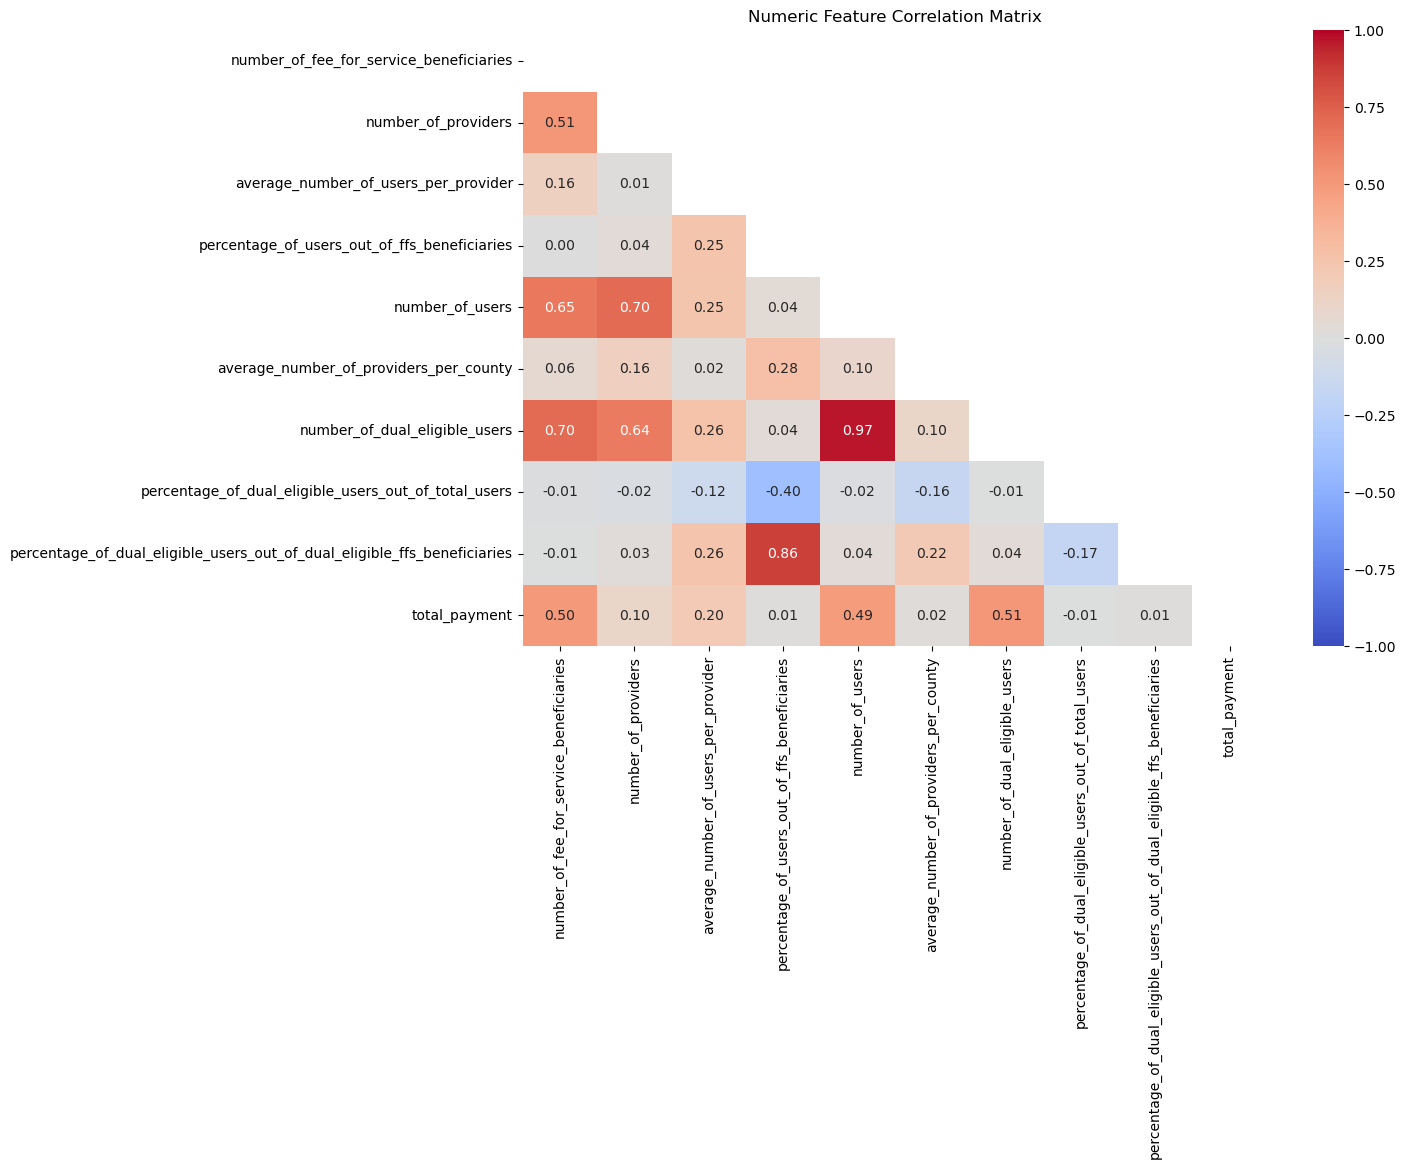

In [27]:
# perform correlation analysis on numeric values 
numeric_data = data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_data.corr()

# create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# plot the upper triangular correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask, vmin=-1, vmax=1)
plt.title('Numeric Feature Correlation Matrix')

There's still a few features that are highly correlated, these features will be removed

#### Feature Reduction
Based on the correlation analysis, highly correlated features are removed to reduce redundancy. Additionally, descriptive columns that do not contribute to the analysis are also dropped.

Removing redundant features helps in reducing complexity and improving the efficiency of subsequent analyses.

In [28]:
# Drop columns that are still highly correlated in the correlation matrix
data = data.drop(columns = ['percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries',
                                            'number_of_dual_eligible_users'])

In [29]:
# drop columns that provided descriptions of the column - they are redundant
data = data.drop(columns = ['aggregation_level','number_of_fee_for_service_beneficiaries_description',
                                       'number_of_providers_description','average_number_of_users_per_provider_description',
                                       'percentage_of_users_out_of_ffs_beneficiaries_description',
                                       'number_of_users_description',
                                       'average_number_of_providers_per_county_description',
                                       'number_of_dual_eligible_users_description',
                                       'percentage_of_dual_eligible_users_out_of_total_users_description',
                                       'percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_description',
                                       'total_payment_description'])

In [30]:
data['average_number_of_users_per_provider']

1           501.47
2           254.97
3           401.34
4           628.07
5          1169.09
            ...   
1044706     129.00
1044707      34.00
1044708      65.00
1044709      34.00
1044710      18.00
Name: average_number_of_users_per_provider, Length: 1044710, dtype: float64

### Duplicate Values 

Checking for duplicates is an essential step in data cleaning to ensure that each entry is unique and that analyses are not skewed by repeated data. There are no duplicate values present. 

In [31]:
# check for duplicates
print('Number of Duplicated Rows:')
data.duplicated().sum() #original df is 1044710 rows 

Number of Duplicated Rows:


0

<div id='visualizations'/>

## Visualizations

### Miscelleanous Plots


#### Bar Plot
The bar plot provides a clear and immediate visual representation of the relative costs of different types of services, helping stakeholders quickly grasp where the highest costs are concentrated and make informed decisions based on this analysis.

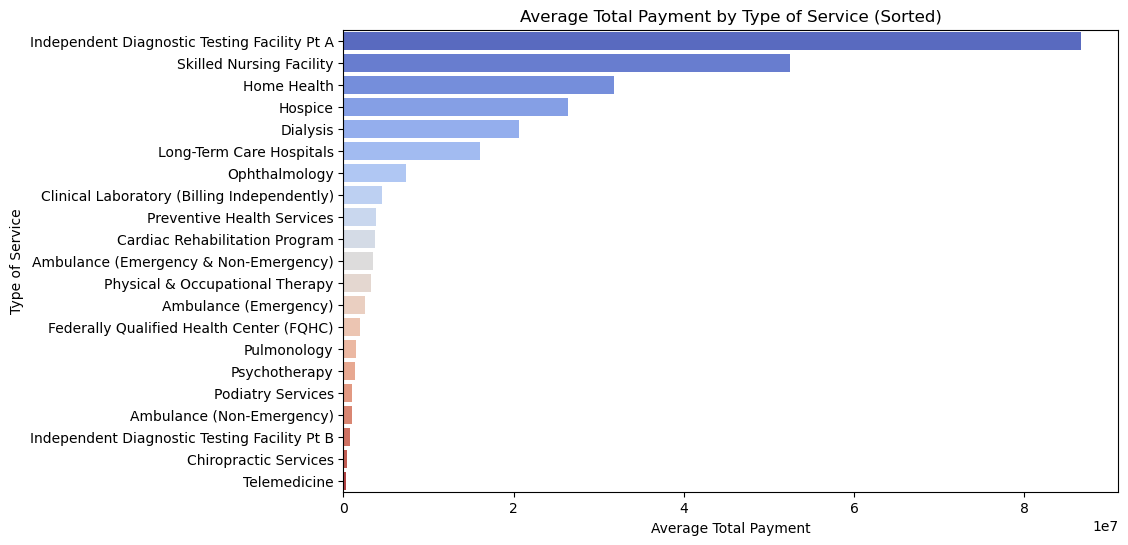

In [32]:
# calculate the average total payment for each type of service
avg_total_payment = data.groupby('type_of_service')['total_payment'].mean().reset_index()

# sort the values from largest to smallest
avg_total_payment_sorted = avg_total_payment.sort_values(by='total_payment', ascending=False)

# create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='total_payment', y='type_of_service', data=avg_total_payment_sorted, palette='coolwarm')
plt.title('Average Total Payment by Type of Service (Sorted)')
plt.xlabel('Average Total Payment')
plt.ylabel('Type of Service')
plt.show()

From the plot it can be conclude:
- Highest Average Payment: Independent Diagnostic Testing PT A has the highest average total payment among the types of services. This suggests that, on average, this type of service incurs the highest costs.

Ranking of Services: The other services follow in the ranking of average payments:
- Skilled Nursing
- Home Health

#### Scatter Plot

This scatter plot helps in understanding the relationship between payments and the number of providers, segmented by service type. This can be valuable for making decisions about resource allocation, identifying high-cost areas, and understanding service-specific trends.

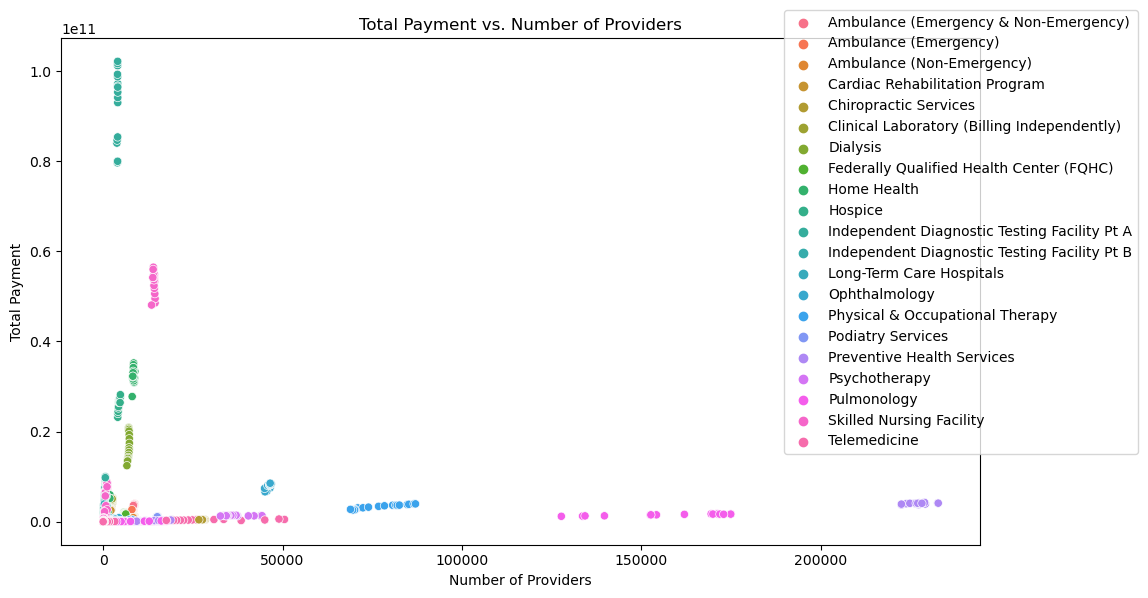

In [33]:
# define plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=data, x='number_of_providers', y='total_payment', hue='type_of_service', ax=ax)
plt.title('Total Payment vs. Number of Providers')
plt.xlabel('Number of Providers')
plt.ylabel('Total Payment')

# remove the legend from the axes
ax.legend_.remove()

# add legend in a separate subplot
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15, 1))

plt.tight_layout()  
plt.show()

### Numeric and Categorical Data Identification
The initial step involves distinguishing between numeric and categorical columns. This separation is critical for tailored analysis and visualization, as numeric and categorical data require distinct methods for processing and interpretation.

In [34]:
# Define numeric data
numeric_data = data.select_dtypes(include=['float', 'int']) #select only float64 columns
numeric_data_columns = numeric_data.columns.tolist()  
print("Numeric Data Columns:")
print(numeric_data_columns)
print()

# Define categorical data
cat_data = data.select_dtypes(include=['object'])  # select only object (string) columns
cat_data_columns = cat_data.columns.tolist() 
print("Categorical Data Columns:")
print(cat_data_columns)
print()

Numeric Data Columns:
['number_of_fee_for_service_beneficiaries', 'number_of_providers', 'average_number_of_users_per_provider', 'percentage_of_users_out_of_ffs_beneficiaries', 'number_of_users', 'average_number_of_providers_per_county', 'percentage_of_dual_eligible_users_out_of_total_users', 'total_payment']

Categorical Data Columns:
['reference_period', 'type_of_service', 'state', 'county', 'state_fips', 'county_fips', 'moratorium', 'number_of_fee_for_service_beneficiaries_dual_color', 'number_of_providers_dual_color', 'average_number_of_users_per_provider_dual_color', 'percentage_of_users_out_of_ffs_beneficiaries_dual_color', 'number_of_users_dual_color', 'average_number_of_providers_per_county_dual_color', 'number_of_dual_eligible_users_dual_color', 'percentage_of_dual_eligible_users_out_of_total_users_dual_color', 'percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color', 'total_payment_dual_color']



### Box Plots

Box plots are used to visualize the distribution of numeric data, showing central tendencies and variability. These plots are arranged in a grid, keeping all outliers to capture the full range of data. This ensures that even extreme values are considered in our analysis.

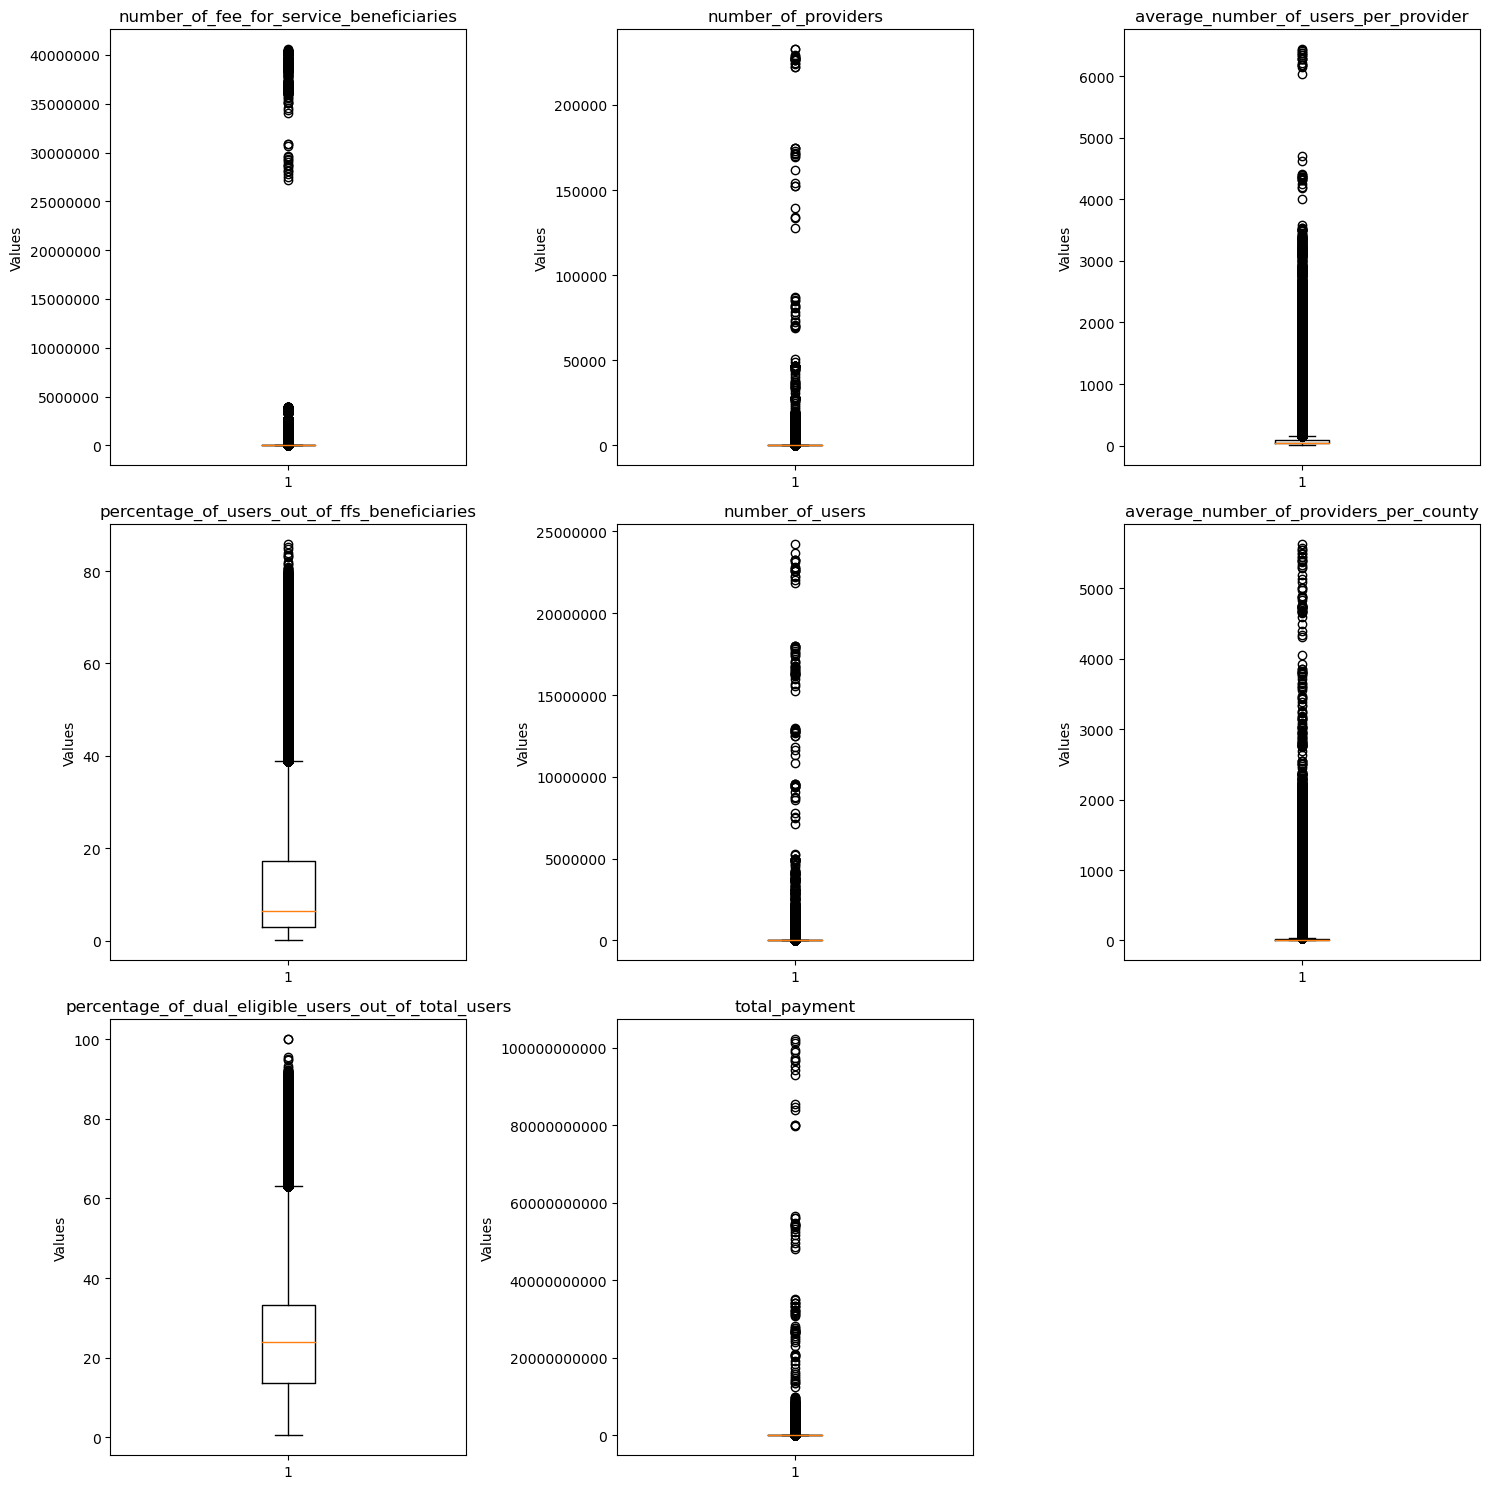

In [35]:
# get number of columns in numeric_data
num_columns = len(numeric_data.columns)

# calculate the number of rows and columns needed for the subplot grid
num_rows = (num_columns - 1) // 3 + 1 
num_cols = min(num_columns, 3)  

# create the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
#flatten the axes array 
axes = axes.flatten()

# plotboxplots for numerical columns 
for i, column in enumerate(numeric_data.columns):
    axes[i].boxplot(numeric_data[column].dropna())
    axes[i].set_title(f'{column}')
    axes[i].set_ylabel('Values')
    axes[i].ticklabel_format(style='plain', axis='y')
    

# hide empty subplots if there are more axes than needed
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Histograms

Histograms illustrate the frequency distribution of numeric columns. Each histogram displays how data values are distributed across different bins, helping us understand the shape and spread of the data.

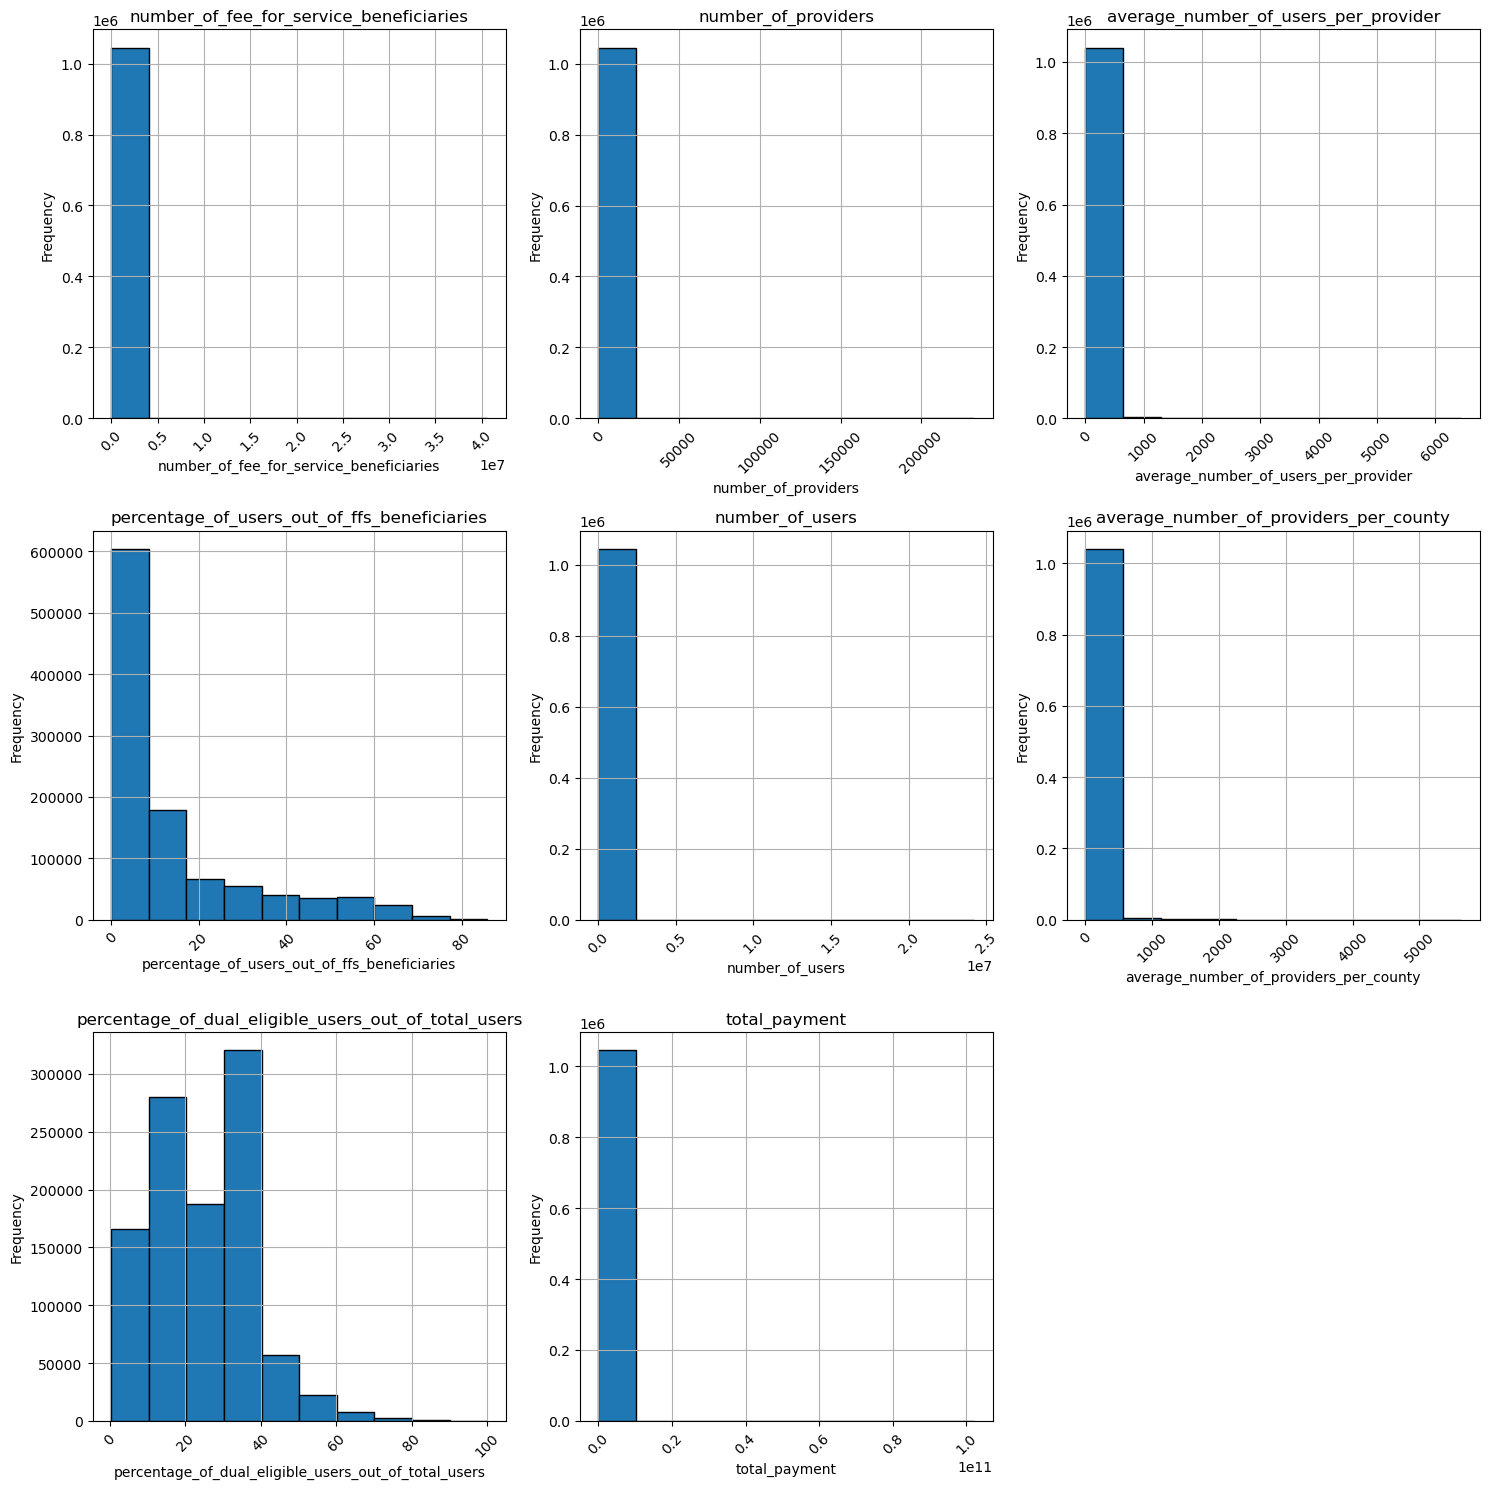

In [36]:
# get number of columns in numeric_data
num_columns = len(numeric_data.columns)

# calculate the number of rows and columns needed for the subplot grid
num_rows = (num_columns - 1) // 3 + 1 
num_cols = min(num_columns, 3)  

# create the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

# flatten the axes array to simplify indexing
axes = axes.flatten()

# Plot histograms for each column using Matplotlib
for i, column in enumerate(numeric_data.columns):
    ax = axes[i]
    ax.hist(numeric_data[column], bins=10, edgecolor='black') 
    ax.set_title(f'{column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True)  # Add grid for better visibility

# hide empty subplots if there are more axes than needed
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Summary Statistics

The summary statistics provide key insights into the numeric columns of the dataset. It reveals central tendencies (mean and median), variability (standard deviation), and the range of values (minimum and maximum). 
This summary helps us understand the overall distribution and scale of the data, highlighting any significant variations and potential data quality issues.

In [37]:
# summary statistics
numeric_data.describe()

,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,number_of_users,average_number_of_providers_per_county,percentage_of_dual_eligible_users_out_of_total_users,total_payment
count,1.044710e+06,1.044710e+06,1.044710e+06,1.044710e+06,1.044710e+06,1.044710e+06,1.044710e+06,1.044710e+06
mean,3.879750e+04,4.590741e+01,8.135521e+01,1.383453e+01,5.394286e+03,2.397508e+01,2.439207e+01,1.289917e+07
std,7.156326e+05,1.233758e+03,1.170855e+02,1.673264e+01,1.552258e+05,9.465588e+01,1.283742e+01,4.817444e+08
min,2.500000e+01,0.000000e+00,1.500000e+00,1.000000e-02,1.100000e+01,0.000000e+00,4.700000e-01,2.913100e+02
25%,2.203000e+03,2.000000e+00,3.400000e+01,2.910000e+00,9.200000e+01,2.000000e+00,1.354000e+01,7.729715e+04
50%,4.543000e+03,5.000000e+00,4.952000e+01,6.470000e+00,3.140000e+02,5.000000e+00,2.388000e+01,3.756805e+05
75%,1.192600e+04,1.600000e+01,8.500000e+01,1.730000e+01,1.171000e+03,1.600000e+01,3.333000e+01,1.981957e+06
max,4.058377e+07,2.327730e+05,6.440620e+03,8.583000e+01,2.422417e+07,5.625000e+03,1.000000e+02,1.021595e+11


### Count Plots
Count plots visualize the frequency of each category in the categorical columns.Thesse plolts can be used to see how dual color categories are distributed, helping to identify any imbalances or trends.

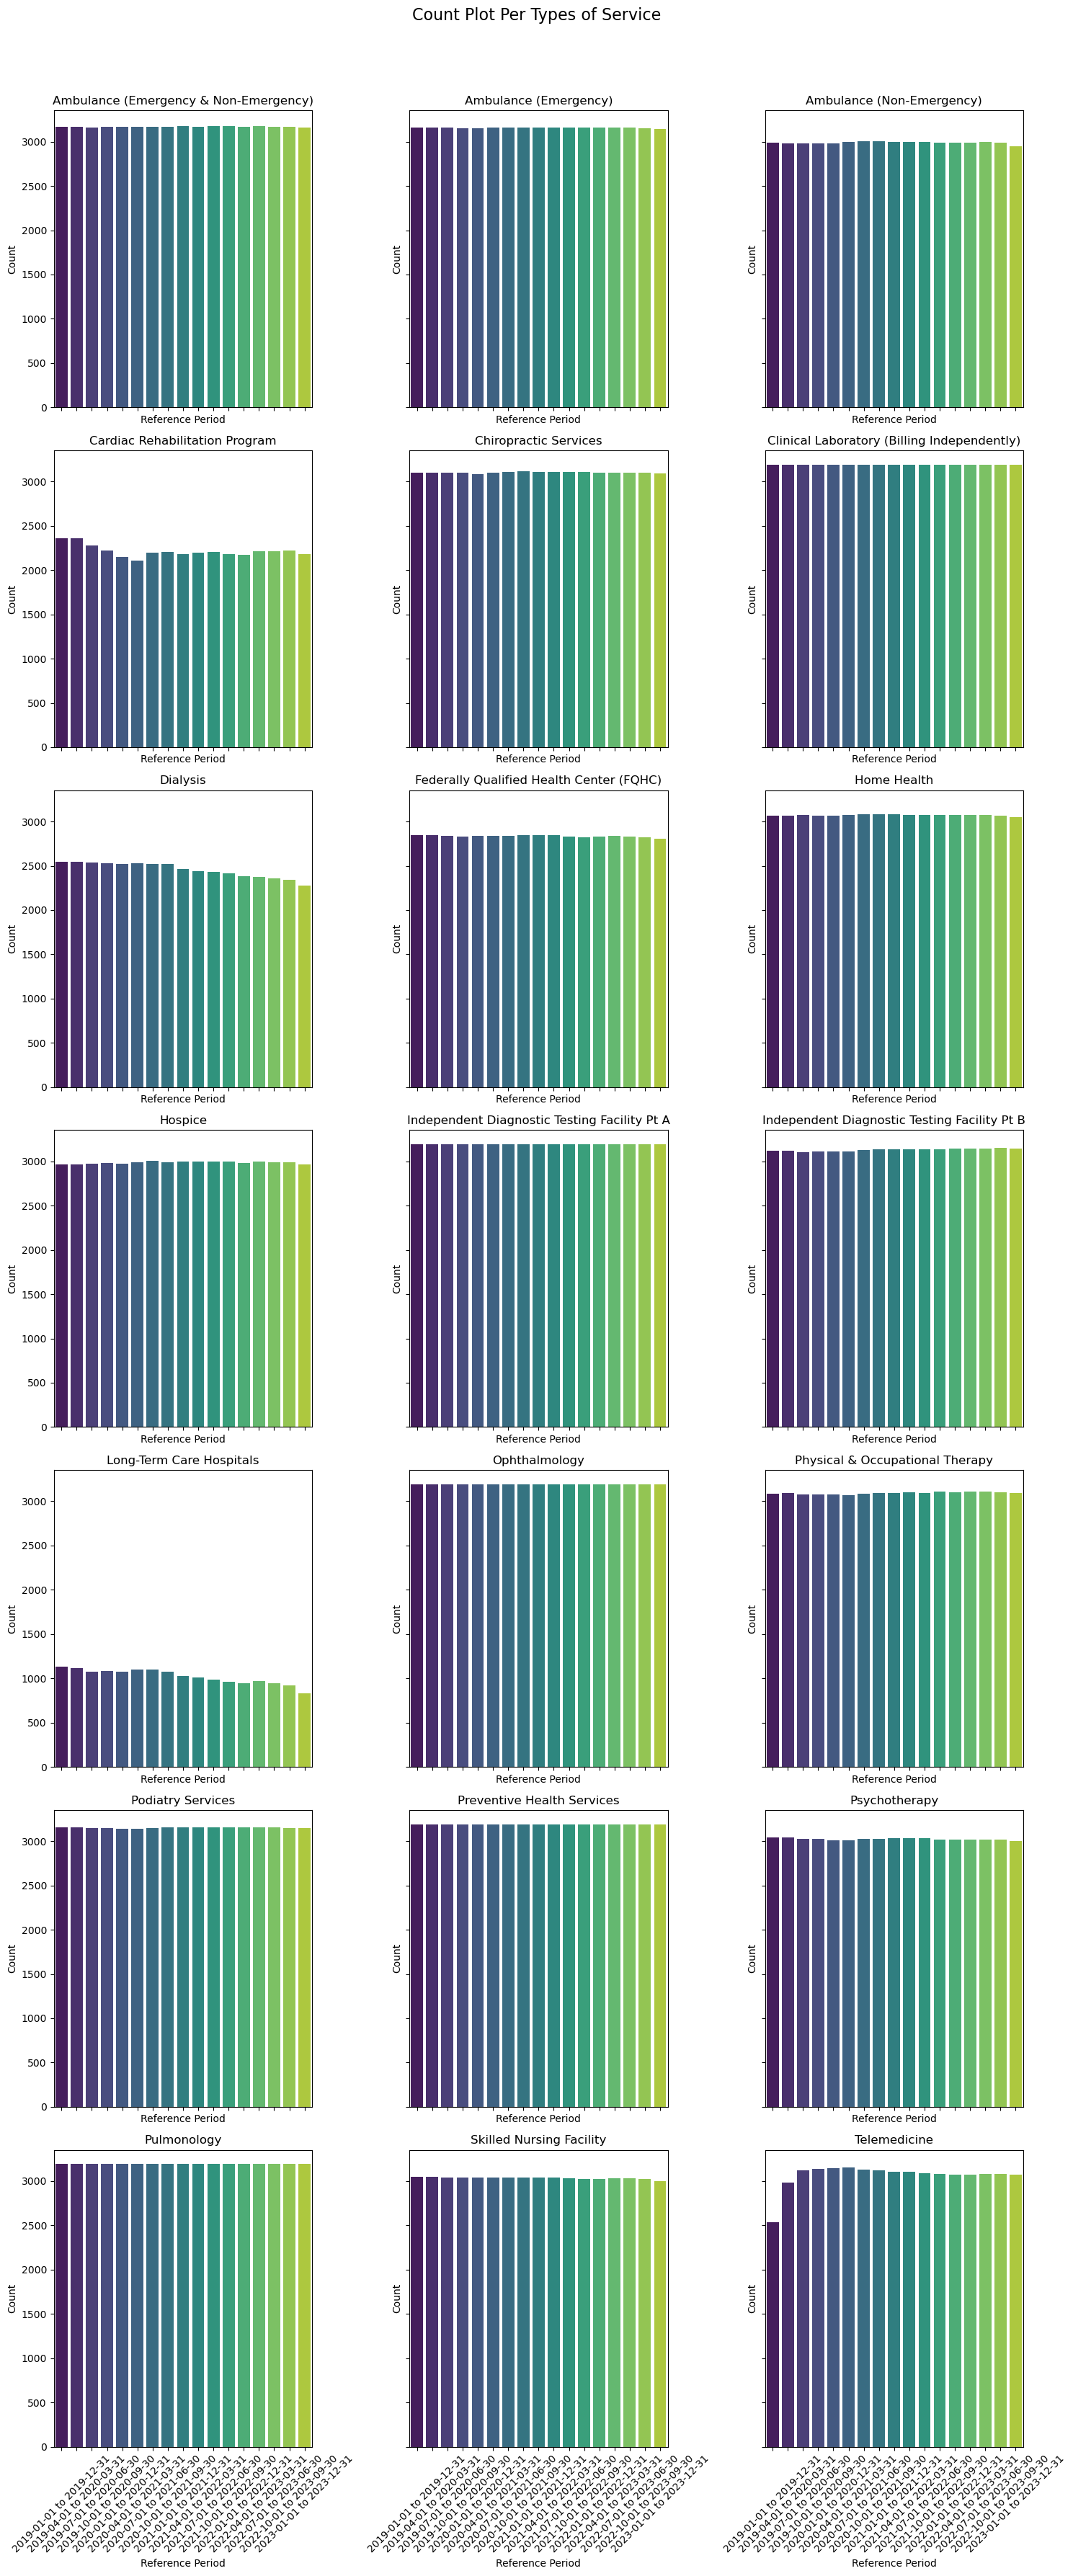

In [38]:
# define a color palette for countplots using the "coolwarm" palette
color_palette = sns.color_palette("viridis", 18)  

# function to plot countplots with the specified color palette
def countplot_with_palette(data, column, ax, palette, **kwargs):
    sns.countplot(x=column, data=data, ax=ax, palette=palette, **kwargs)

# get unique types of services
types_of_service = cat_data['type_of_service'].unique()

# determine the number of rows and columns for subplots
n_types = len(types_of_service)
n_cols = 3  # Number of columns in the grid
n_rows = (n_types + n_cols - 1) // n_cols  # Number of rows

# create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), sharex=True, sharey=True)

# flatten the axes array for easy iteration
axes = axes.flatten()

# plot each type of service
for i, service_type in enumerate(types_of_service):
    #fFilter data for the current type of service
    service_data = cat_data[cat_data['type_of_service'] == service_type]
    countplot_with_palette(service_data, 'reference_period', ax=axes[i], palette=color_palette)
    
    # set the title for the subplot
    axes[i].set_title(f'{service_type}')
    axes[i].set_xlabel('Reference Period')
    axes[i].set_ylabel('Count')

# hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# set the main title for the figure
plt.suptitle('Count Plot Per Types of Service', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

From the countplot above, it is evident that a majority of the types of services are evenly distributed with a few exceptions such as long-term care hospitals. 

In the context of Medicare claims analysis, 'BLUE 1' through 'BLUE 5' represent varying levels of claim severity or service types, with 'BLUE 1' indicating the lightest or least severe cases and 'BLUE 5' representing the most severe or complex cases, allowing for a nuanced view of data distribution across different claim categories.

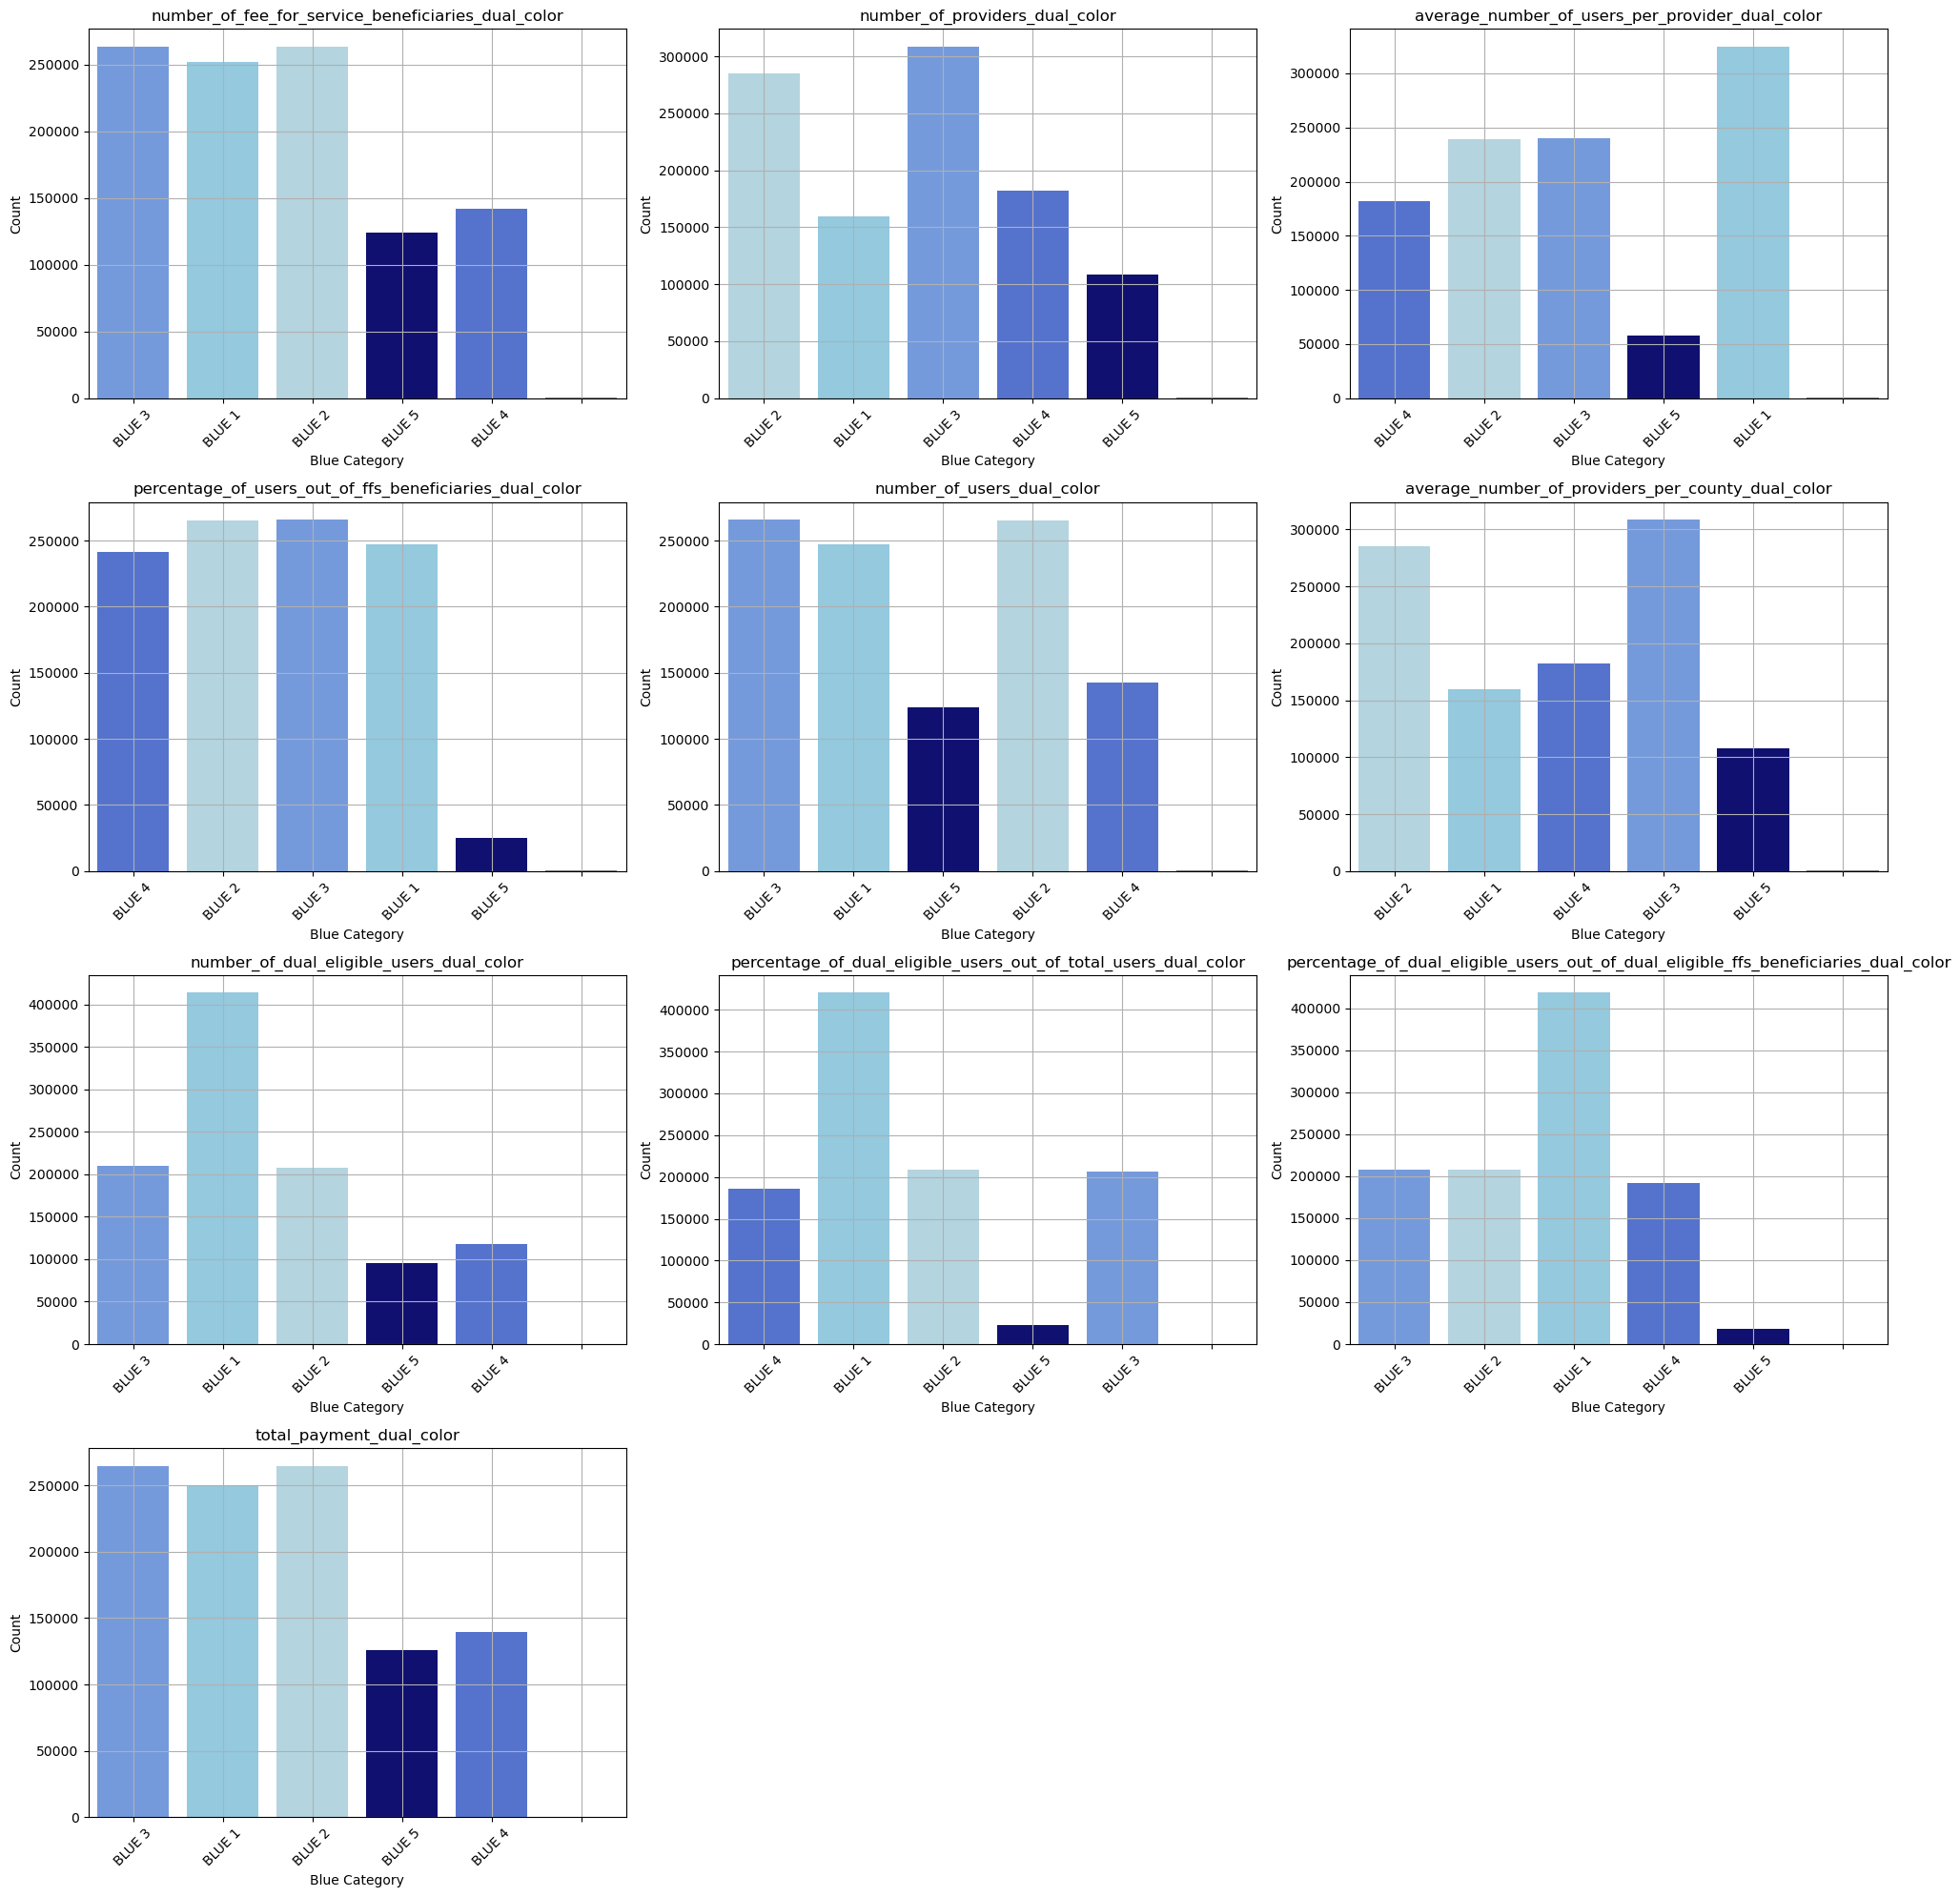

In [39]:
#define a color palette with 5 shades for BLUE categories
blue_palette = {
    'BLUE 1': 'skyblue',        # Lightest blue
    'BLUE 2': 'lightblue',      # Slightly darker
    'BLUE 3': 'cornflowerblue', # Medium blue
    'BLUE 4': 'royalblue',      # Darker blue
    'BLUE 5': 'navy'            # Darkest blue
}

# select specific categorical columns from index 7 onward
categorical_columns = cat_data.iloc[:, 7:].select_dtypes(include=['object']).columns

# get number of columns in the selected categorical data
num_columns = len(categorical_columns)

# calculate number of rows and columns needed for the subplot grid
num_rows = (num_columns - 1) // 3 + 1 
num_cols = min(num_columns, 3)  

# create a figure and axes for subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))

# flatten the axes array to simplify indexing
axes = axes.flatten()

# function to plot countplots with color differentiation
def countplot_with_color(data, column, ax, **kwargs):
    unique_vals = data[column].unique()
    # Create a palette for only the unique values present in the column
    palette = {val: blue_palette.get(val, 'grey') for val in unique_vals}
    sns.countplot(x=column, data=data, palette=palette, ax=ax, **kwargs)

# plotting count plots for each categorical column
for i, column in enumerate(categorical_columns):
    countplot_with_color(cat_data, column, ax=axes[i])
    axes[i].set_title(f'{column}')
    axes[i].set_xlabel('Blue Category')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True)

# hide empty subplots if there are more axes than needed
for j in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[j])
        
plt.tight_layout() 
plt.show()

#### Removal of 'BLUE' and Data Type Conversion
However, for our current data analysis and modeling purposes, the focus is exclusively on the numeric values within these columns. The presence of 'BLUE' does not contribute to numerical computations and statistical analyses, which require consistent numeric formats across datasets.

Therefore, by removing 'BLUE' from each element in these columns using the following Python code:


In [40]:
df = data.copy() #create a copy of the df to work on 
numeric_columns = numeric_data.columns.tolist() # list of our numeric columns

In [41]:
# Remove 'BLUE' from each element in the relevant columns
for column in df.columns[15:]:  
    df[column] = df[column].astype(str).str.replace('BLUE', '').str.strip()
    df[column] = pd.to_numeric(df[column], errors='coerce')

#drop any NA values created during the process 
df.dropna(subset=df.columns[15:], inplace=True)
    
df[df.columns[15:]] = df[df.columns[15:]].astype(int)

In [42]:
df.head(5) #ensure 'BLUE' was removed from the appropriate columns 

,reference_period,type_of_service,state,county,state_fips,county_fips,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,...,number_of_fee_for_service_beneficiaries_dual_color,number_of_providers_dual_color,average_number_of_users_per_provider_dual_color,percentage_of_users_out_of_ffs_beneficiaries_dual_color,number_of_users_dual_color,average_number_of_providers_per_county_dual_color,number_of_dual_eligible_users_dual_color,percentage_of_dual_eligible_users_out_of_total_users_dual_color,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color,total_payment_dual_color
1,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),AL,--ALL--,01,,547486.0,146.0,501.47,13.37,...,3,2,4,4,3,2,3,4,3,3
2,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),AK,--ALL--,02,,91480.0,33.0,254.97,9.20,...,1,1,2,2,1,1,1,4,2,1
3,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),AZ,--ALL--,04,,740278.0,170.0,401.34,9.22,...,3,3,3,2,3,4,2,1,1,2
4,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),AR,--ALL--,05,,437616.0,86.0,628.07,12.34,...,2,2,4,3,3,2,1,1,1,3
5,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),CA,--ALL--,06,,3423285.0,330.0,1169.09,11.27,...,5,4,5,2,5,4,5,4,2,5


<div id='feature-selection'/>

## Feature Selection

### Target Variable 

A target variable, `potential_fwa`, was created to identify potential cases of fraud, waste, and abuse (FWA) in healthcare service utilization data. It was derived by applying logical conditions based on anomalies in `number_of_fee_for_service_beneficiaries_dual_color` and unusually high `total_payment_dual_color` values, aiming to flag instances warranting further investigation for potential fraudulent activities.

In [43]:
# print summary statistics for two columns 
print(df['number_of_fee_for_service_beneficiaries'].describe())
print(df['total_payment_dual_color'].describe())

count    1.044354e+06
mean     2.586350e+04
std      1.389055e+05
min      2.500000e+01
25%      2.203000e+03
50%      4.541000e+03
75%      1.190600e+04
max      3.897705e+06
Name: number_of_fee_for_service_beneficiaries, dtype: float64
count    1.044354e+06
mean     2.644667e+00
std      1.302929e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: total_payment_dual_color, dtype: float64


The summary statistics of `number_of_fee_for_service_beneficiaries` and `total_payment_dual_color` are examined to understand the distribution and scale of these columns. The output provides insights into the mean, standard deviation, minimum, maximum, and quartiles of these columns.



#### Defining Conditions for Potential FWA

Conditions are defined to identify potential FWA cases. `condition_blue` checks if the `number_of_fee_for_service_beneficiaries_dual_color` is in the set [4, 5], and `condition_payment` identifies unusually high payment values. The `potential_fwa` column is created by combining these conditions using a logical OR operator.

In [44]:
# define conditions for potential FWA
condition_blue = df['number_of_fee_for_service_beneficiaries_dual_color'].isin([4, 5])  # Adjust as needed based on data exploration
condition_payment = df['total_payment_dual_color'] > (df['total_payment_dual_color'].mean() + 2 * df['total_payment_dual_color'].std())

# create the 'potential_fwa' column
df['potential_fwa'] = np.where(condition_blue | condition_payment, 1, 0)

# print sample to verify
print(df[['number_of_fee_for_service_beneficiaries_dual_color', 'total_payment_dual_color', 'potential_fwa']].head(10))

    number_of_fee_for_service_beneficiaries_dual_color  \
1                                                   3    
2                                                   1    
3                                                   3    
4                                                   2    
5                                                   5    
6                                                   3    
7                                                   2    
8                                                   1    
9                                                   1    
10                                                  5    

    total_payment_dual_color  potential_fwa  
1                          3              0  
2                          1              0  
3                          2              0  
4                          3              0  
5                          5              1  
6                          2              0  
7                          3           

In [45]:
# print value counts 
fwa_counts = df['potential_fwa'].value_counts()
fwa_counts

potential_fwa
0    778874
1    265480
Name: count, dtype: int64

The value counts of the `potential_fwa` column are printed to understand the distribution of flagged cases. It is evident that there is an imabalnce between the two classes:
- 0 (no potential FWA) 
- 1 (potential FWA).

To prepare for One-Hot Encoding, the relevant columns back to categorical data types.

In [46]:
# change the columns back into onjects for orig df
df.iloc[:,15:] = df.iloc[:,15:].astype('category')

In [83]:
# save df to CSV 
csv_path = 'data/df_fwa.csv'
df.to_csv(csv_path, index=False)

print(f"DataFrame successfully saved to {csv_path}")

DataFrame successfully saved to data/df_fwa.csv


### *One Hot Encoding*
The categorical columns are selected and One-Hot Encoding is applied to convert these columns into binary indicator variables. This process helps in transforming the categorical data into a format suitable for machine learning models.

In [47]:
cat_data = df.select_dtypes(include=['category'])  # select only object (string) columns
cat_data_columns = cat_data.columns.tolist()
cat_data_columns.remove('potential_fwa')

# One-Hot Encoding
one_hot_encoded_df = pd.get_dummies(df, columns= cat_data_columns)

In [48]:
# Display the One-Hot Encoded DataFrame
print("\nOne-Hot Encoded DataFrame:")
one_hot_encoded_df


One-Hot Encoded DataFrame:


,reference_period,type_of_service,state,county,state_fips,county_fips,number_of_fee_for_service_beneficiaries,number_of_providers,average_number_of_users_per_provider,percentage_of_users_out_of_ffs_beneficiaries,...,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color_1,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color_2,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color_3,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color_4,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color_5,total_payment_dual_color_1,total_payment_dual_color_2,total_payment_dual_color_3,total_payment_dual_color_4,total_payment_dual_color_5
1,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),AL,--ALL--,01,,547486.0,146.0,501.47,13.37,...,False,False,True,False,False,False,False,True,False,False
2,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),AK,--ALL--,02,,91480.0,33.0,254.97,9.20,...,False,True,False,False,False,True,False,False,False,False
3,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),AZ,--ALL--,04,,740278.0,170.0,401.34,9.22,...,True,False,False,False,False,False,True,False,False,False
4,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),AR,--ALL--,05,,437616.0,86.0,628.07,12.34,...,True,False,False,False,False,False,False,True,False,False
5,2019-01-01 to 2019-12-31,Ambulance (Emergency & Non-Emergency),CA,--ALL--,06,,3423285.0,330.0,1169.09,11.27,...,False,True,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044706,2023-01-01 to 2023-12-31,Telemedicine,WY,SWEETWATER,56,037,7236.0,2.0,129.00,3.57,...,False,False,False,True,False,False,False,True,False,False
1044707,2023-01-01 to 2023-12-31,Telemedicine,WY,TETON,56,039,4139.0,0.0,34.00,2.63,...,True,False,False,False,False,False,False,True,False,False
1044708,2023-01-01 to 2023-12-31,Telemedicine,WY,UINTA,56,041,3413.0,2.0,65.00,3.81,...,False,False,False,True,False,False,False,True,False,False
1044709,2023-01-01 to 2023-12-31,Telemedicine,WY,WASHAKIE,56,043,1979.0,0.0,34.00,1.77,...,True,False,False,False,False,False,True,False,False,False


### Chi-Square

A Chi-Square test is performed to determine the statistical significance of each feature in relation to the `potential_fwa` target variable. All columns, excluding the target column, are iterated through, and the Chi-Square value, p-value, degrees of freedom, and expected frequencies for each feature are calculated. The results are stored in a DataFrame for analysis.

In [49]:
# define target column to be analyzed for assocation 
target_column = 'potential_fwa'

# create an empty array to store the results of chi-square test
chi_results = []

# iterate through all columns (excluding the target column)
for column in df.columns:
    if column != target_column:
        # create a contingency table for the independent and target variable
        cross_tab = pd.crosstab(index=df[column], columns=df[target_column])
        # perform chi-square test
        chi2, p, dof, expected = chi2_contingency(cross_tab)
        # append results to the list
        chi_results.append({
            'Variable': column,
            'Chi-Square Value': chi2,
            'P-Value': p,
            'Degrees of Freedom': dof
        })


# display results in a df 
chi_df = pd.DataFrame(chi_results)
chi_df

,Variable,Chi-Square Value,P-Value,Degrees of Freedom
0,reference_period,3.259824e-01,1.000000,16
1,type_of_service,1.997083e+01,0.459756,20
2,state,2.053347e+05,0.000000,50
3,county,5.952172e+05,0.000000,1838
4,state_fips,2.053347e+05,0.000000,50
5,county_fips,9.312658e+04,0.000000,325
6,number_of_fee_for_service_beneficiaries,9.597703e+05,0.000000,38610
7,number_of_providers,2.932114e+05,0.000000,3301
8,average_number_of_users_per_provider,3.025570e+05,0.000000,46340
9,percentage_of_users_out_of_ffs_beneficiaries,1.958181e+04,0.000000,7779


Based on the chi-square test, teh following insights can be derived:

High P-Values (suggesting to drop):
- `reference_period` (P-Value = 1.000000)
- `type_of_service` (P-Value = 0.459756)
- `moratorium` (P-Value = 1.000000)

These columns have high p-values, suggesting they may not be statistically significant for our analysis and could be considered for dropping.

Low P-Values (suggesting to keep):
Columns such as `state`, `county`, `state_fips`, `county_fips`, etc., have very low p-values (0.000000), indicating strong statistical significance and should be kept for further analysis.

### Variance Inflation Factor

The Variance Inflation Factor (VIF) is calculated to assess multicollinearity among the numeric features. High VIF values indicate strong correlations between the features, which can affect model performance. 

In [50]:
numeric_data = df.select_dtypes(include=['float']) #seperate numeric data 
#numeric_data = numeric_data.drop(columns = 'potential_fwa')

# create a df for VIF values
vif = pd.DataFrame()
vif["Variable"] = numeric_data.columns

# calculate/store VIF values for each numeric variable
vif["VIF"] = [variance_inflation_factor(numeric_data.values, i) for i in range(numeric_data.shape[1])]
vif

,Variable,VIF
0,number_of_fee_for_service_beneficiaries,2.049441
1,number_of_providers,3.354801
2,average_number_of_users_per_provider,2.288662
3,percentage_of_users_out_of_ffs_beneficiaries,1.717902
4,number_of_users,3.573852
5,average_number_of_providers_per_county,1.628155
6,percentage_of_dual_eligible_users_out_of_total...,1.430058
7,total_payment,1.604040


To reduce multicollinearity, columns containing the word `average` are removed. The VIF values for the remaining numeric features are then recalculated to ensure the effectiveness of the feature selection process.

In [51]:
# remove columns with the word 'average for dataframes 'df' and 'data_transformed' 
columns_to_drop = [col for col in df.columns if 'average' in col]
df = df.drop(columns=columns_to_drop)

In [52]:
# data after removal of above columns
numeric_data = df.select_dtypes(include=['float', 'int']) #define numeric data 

# create a df for VIF values
vif = pd.DataFrame()
vif["Variable"] = numeric_data.columns

# calculate/store VIF values for each numeric variable
vif["VIF"] = [variance_inflation_factor(numeric_data.values, i) for i in range(numeric_data.shape[1])]
vif

,Variable,VIF
0,number_of_fee_for_service_beneficiaries,2.018410
1,number_of_providers,2.348720
2,percentage_of_users_out_of_ffs_beneficiaries,1.267970
3,number_of_users,2.971019
4,percentage_of_dual_eligible_users_out_of_total...,1.242257
5,total_payment,1.585142


Removing the variables containing the word `average` slightly impacted the VIF scores of the remaining variables.

The decision was made to remove them as they might utlizing other columns to generate the values within the column. 

Despite the transformation, variables such as `number_of_fee_for_service_beneficiaries`, `number_of_users`, and `number_of_users_dual_color` still exhibit extremely high VIF scores, indicating persistent multicollinearity issues.

To address this, Principal Component Analysis (PCA) can be applied to reduce multicollinearity.



### Correlation with Target Column (`potential_fwa`)

In [53]:
# convert 'potential_fwa' to numeric
df_corr = df.copy() #create copy of df 
df_corr['potential_fwa'] = pd.to_numeric(df_corr['potential_fwa'], errors='coerce')

# select numeric columns for correlation analysis
numeric_cols = df_corr.select_dtypes(include=['float', 'int']).columns

# calculate the correlation matrix
corr_matrix = df_corr[numeric_cols].corr()

if 'potential_fwa' in corr_matrix.columns:
    target_corr = corr_matrix['potential_fwa']
    print('Correlation with Target Column (`potential_fwa`):')
    print(target_corr)

Correlation with Target Column (`potential_fwa`):
number_of_fee_for_service_beneficiaries                 0.189170
number_of_providers                                     0.133920
percentage_of_users_out_of_ffs_beneficiaries            0.039423
number_of_users                                         0.123781
percentage_of_dual_eligible_users_out_of_total_users   -0.174868
total_payment                                           0.091314
potential_fwa                                           1.000000
Name: potential_fwa, dtype: float64


The following columns have low or near-zero correlations with `potential_fwa`, suggesting they may have less impact on predicting the target variable and can be evaluated for removal:

- `percentage_of_users_out_of_ffs_beneficiaries`: 0.0394
- `number_of_users`: 0.1238
- `percentage_of_dual_eligible_users_out_of_total_users`: -0.1749
- `percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries`: -0.0424
- `total_payment`: 0.0913

Text(0.5, 1.0, 'Correlation Matrix with Target Column (potential_fwa)')

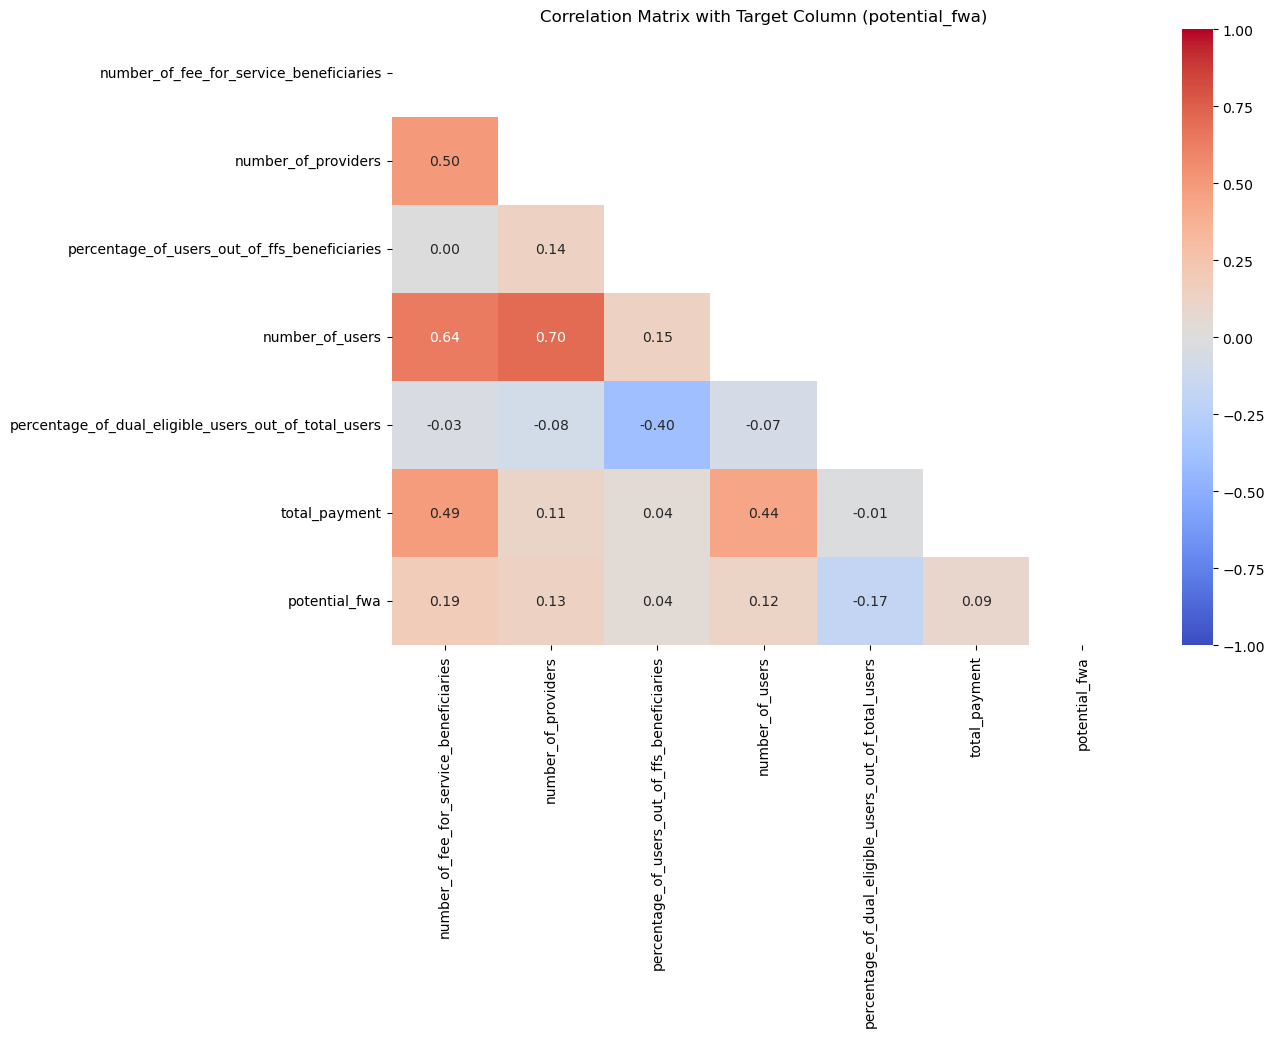

In [54]:
# create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# plot the upper triangular correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Matrix with Target Column (potential_fwa)')

The following columns will be removed due to their high p-values, multicollinearity, and minimal correlation with the target variable:

- `moratorium`
- `reference_period`

Additionally, the columns `number_of_fee_for_service_beneficiaries_dual_color` and `total_payment_dual_color` will be dropped as they derived the `potential_fwa` variable.

### Drop Columns with High p-values and Redundancy

Columns with high p-values and redundancy are removed to improve the model's performance and reduce multicollinearity.


In [55]:
# set up dataframes before splitting
# these columns were removed because of the high pvalues and redundancy
columns_to_drop = [
    'moratorium',
    'reference_period',
    'state_fips',
    'county_fips']

data_for_split = one_hot_encoded_df.drop(columns_to_drop, axis = 1)

<div id='train-test-and-validation-split'/>

## Train, Test, and Validation Split

To evaluate our machine learning model's performance accurately,  the dataset is split into training, validation, and test sets. This ensures the model can generalize well to unseen data.

### Encoding Categorical Columns

Binary encoding is applied to categorical columns to convert them into a numerical format suitable for machine learning algorithms.

In [56]:
# Encode the column for state, type_of_service, county, state_fips, and county_fips
# Apply binary encoding to the categorical columns
encoder = ce.BinaryEncoder(cols=['type_of_service','state', 'county'])
data_for_split_encoded = encoder.fit_transform(data_for_split)

### Splitting Data into Training, Validation, and Test Sets

The encoded DataFrame is split into training, validation, and test sets, ensuring the class distribution is preserved using stratification.
The data is split in the following manner:
- Training: 70%
- Test: 15%
- Validation: 15%

In [57]:
# split into X and y dataframes
# Split the encoded DataFrame into training and test sets
# Separate features and target
y = data_for_split_encoded['potential_fwa']
X = data_for_split_encoded.drop(columns=['potential_fwa'])

# Split into training and test sets with stratification
# Step 1: Split into 70% training and 30% temporary set
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,
    stratify=y  # Ensures the class distribution is preserved
)


# Split the training set into training and validation sets with stratification
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.5,  # Split the temporary set equally into validation and test sets
    random_state=42,
    stratify=y_temp  # Ensures the class distribution is preserved
)

In [58]:
print("Training features:")
X_train.head()

Training features:


,type_of_service_0,type_of_service_1,type_of_service_2,type_of_service_3,type_of_service_4,state_0,state_1,state_2,state_3,state_4,...,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color_1,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color_2,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color_3,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color_4,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color_5,total_payment_dual_color_1,total_payment_dual_color_2,total_payment_dual_color_3,total_payment_dual_color_4,total_payment_dual_color_5
794169,1,0,1,0,0,0,0,1,0,1,...,False,False,True,False,False,True,False,False,False,False
305065,1,0,1,0,1,0,0,1,0,1,...,False,True,False,False,False,False,False,True,False,False
303479,1,0,1,0,0,1,0,0,0,1,...,True,False,False,False,False,False,False,False,True,False
847008,1,0,0,0,1,0,1,0,1,1,...,True,False,False,False,False,False,False,True,False,False
760877,0,1,0,0,0,1,0,1,0,0,...,False,False,True,False,False,False,False,False,True,False


In [59]:
print("\nTest features:")
X_test.head()


Test features:


,type_of_service_0,type_of_service_1,type_of_service_2,type_of_service_3,type_of_service_4,state_0,state_1,state_2,state_3,state_4,...,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color_1,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color_2,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color_3,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color_4,percentage_of_dual_eligible_users_out_of_dual_eligible_ffs_beneficiaries_dual_color_5,total_payment_dual_color_1,total_payment_dual_color_2,total_payment_dual_color_3,total_payment_dual_color_4,total_payment_dual_color_5
117570,1,0,1,0,0,0,0,1,1,0,...,True,False,False,False,False,False,True,False,False,False
663493,1,0,0,0,1,0,1,1,1,1,...,False,False,True,False,False,False,False,False,False,True
143438,0,1,0,0,0,1,0,0,0,1,...,False,True,False,False,False,False,False,False,True,False
475415,1,0,0,0,0,0,1,1,0,0,...,True,False,False,False,False,True,False,False,False,False
90111,0,1,0,1,0,1,0,1,1,0,...,False,False,True,False,False,False,False,False,True,False


### Synthetic Minority Over-sampling Technique (SMOTE)

To address the class imbalance in our training data, SMOTE is used to create synthetic examples of the minority class, balancing the labels.

#### Original Training Labels

In [60]:
# balance the labels
# print value counts 
fwa_counts = y_train.value_counts()
fwa_counts

potential_fwa
0    545211
1    185836
Name: count, dtype: int64

This shows that the dataset is imbalanced with significantly fewer examples of the minority class (1) compared to the majority class (0)

#### Resampled Training Labels

After applying SMOTE, the training labels are balanced:

In [61]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print(pd.Series(y_resampled).value_counts())

potential_fwa
0    545211
1    545211
Name: count, dtype: int64


In [62]:
# rename the dataframes
X_train = X_resampled
y_train = y_resampled

### Scaling Data

The training, validation, and test sets are scaled using the RobustScaler, which is less sensitive to outliers compared to standard scaling methods.

#### Identify numeric columns

In [63]:
#set up numeric columns list
x_train_num_cols = X_train.select_dtypes(include=['float'])
x_train_num_cols = x_train_num_cols.columns.tolist()

Initialize scaler and apply to the training, validation, and test datasets:

In [64]:
# Set up scaler
scaler = RobustScaler()

# Apply standardization to each numeric column
X_train_scaled = X_train.copy()
X_train_scaled[x_train_num_cols] = scaler.fit_transform(X_train[x_train_num_cols])

X_val_scaled = X_val.copy()
X_val_scaled[x_train_num_cols] = scaler.transform(X_val_scaled[x_train_num_cols])

X_test_scaled = X_test.copy()
X_test_scaled[x_train_num_cols] = scaler.transform(X_test_scaled[x_train_num_cols])

#### Saving DataFrames to CSV

To ensure reproducibility and ease of access, the processed data is saved to CSV files.

In [65]:
# function to save df into CSV files
def save_to_csv(data, file_name, directory='data'):
    # create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # define path
    output_file = os.path.join(directory, file_name)
    
    # save data to CSV
    data.to_csv(output_file, index=False)
    print(f"DataFrame saved to {output_file}")

# define df and file names
data_files = [
    (X_train, 'x_train.csv'),
    (X_train_scaled, 'x_train_scaled.csv'),
    (y_train, 'y_train.csv'),
    (y_val, 'y_val.csv'),
    (X_val, 'x_val.csv'),
    (X_val_scaled, 'x_val_scaled.csv'),
    (X_test, 'x_test.csv'),
    (X_test_scaled, 'x_test_scaled.csv'),
    (y_test, 'y_test.csv')
]

for data, file_name in data_files:
    save_to_csv(data, file_name)

DataFrame saved to data/x_train.csv
DataFrame saved to data/x_train_scaled.csv
DataFrame saved to data/y_train.csv
DataFrame saved to data/y_val.csv
DataFrame saved to data/x_val.csv
DataFrame saved to data/x_val_scaled.csv
DataFrame saved to data/x_test.csv
DataFrame saved to data/x_test_scaled.csv
DataFrame saved to data/y_test.csv


### Principal Componet Analysis (PCA)
PCA is performed to reduce the dimensionality of the dataset and retain the most significant features.

#### PCA on Unscaled Data:

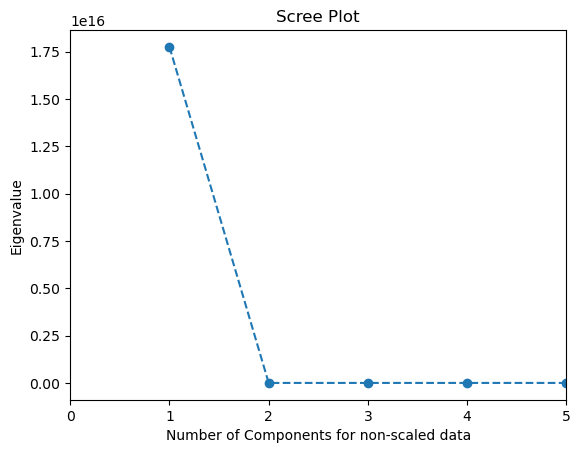

In [66]:
# PCA on unscaled data
pca = PCA()
pca.fit(X_train)
# Plot scree plot
plt.plot(range(1, len(pca.explained_variance_) + 1), 
         pca.explained_variance_, marker='o', linestyle='--')
plt.xlabel('Number of Components for non-scaled data')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.xlim(0,5)
plt.show()

In [67]:
pca_unscaled = PCA(n_components=2)
X_train_pca = pca_unscaled.fit_transform(X_train)
X_val_pca = pca_unscaled.transform(X_val)
X_test_pca = pca_unscaled.transform(X_test)

PCA is performed on the unscaled data, and a scree plot is generated to visualize the variance explained by each principal component. This helps in selecting the number of components to retain - in this case 2. 
#### PCA on Scaled Data:

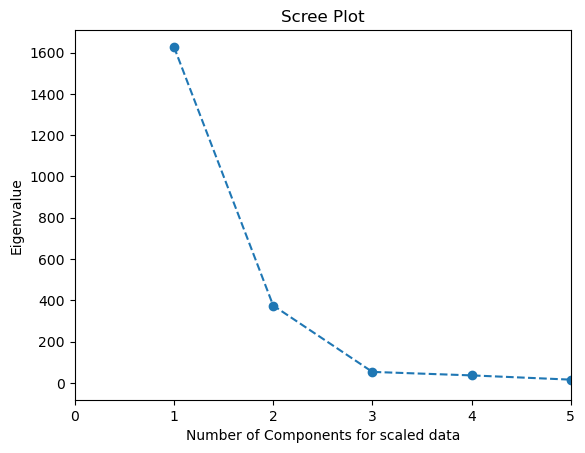

In [68]:
# PCA on scaled df 
pca = PCA()
pca.fit(X_train_scaled)
# Plot scree plot
plt.plot(range(1, len(pca.explained_variance_) + 1), 
         pca.explained_variance_, marker='o', linestyle='--')
plt.xlabel('Number of Components for scaled data')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot')
plt.xlim(0,5)
plt.show()

In [80]:
pca_scaled = PCA(n_components=3)
X_train_scaled_pca = pca_scaled.fit_transform(X_train_scaled)
X_val_scaled_pca = pca_scaled.transform(X_val_scaled)
X_test_scaled_pca = pca_scaled.transform(X_test_scaled)

PCA is applied to the scaled data, and scree plots are generated to compare with the unscaled data. The number of principal componets to retain are 3. 

#### Interpret Loadings

In [70]:
components_unscaled = pca_unscaled.components_
components_scaled = pca_scaled.components_

In [72]:
# Interpret Loadings
loadings_unscaled = pd.DataFrame(components_unscaled.T, columns=[f'PC{i+1}' for i in range(components_unscaled.shape[0])], index=[f'Feature {i+1}' for i in range(components_unscaled.shape[1])])
print(loadings_unscaled)

                     PC1           PC2
Feature 1  -8.120689e-11 -3.399504e-08
Feature 2   1.755986e-10 -1.397935e-07
Feature 3  -9.646246e-11  8.970155e-09
Feature 4   3.282128e-11 -1.134560e-07
Feature 5   4.420076e-11 -8.755915e-08
...                  ...           ...
Feature 76 -1.177447e-10 -1.831425e-07
Feature 77 -1.142922e-10 -1.567700e-07
Feature 78 -1.081352e-10 -9.293063e-08
Feature 79  7.249745e-11  1.254491e-07
Feature 80  2.895427e-10  3.886270e-07

[80 rows x 2 columns]


The loadings_unscaled DataFrame shows the contribution of each feature to the principal components (PC1, PC2) when the data has not been scaled.Small values in the unscaled data might suggest that some features have less impact on the principal components, which could be due to differences in the scale or variance of features.

In [73]:
loadings_scaled = pd.DataFrame(components_scaled.T, columns=[f'PC{i+1}' for i in range(components_scaled.shape[0])], index=[f'Feature {i+1}' for i in range(components_scaled.shape[1])])
print(loadings_scaled)

                 PC1       PC2       PC3
Feature 1  -0.000219  0.001338  0.007427
Feature 2   0.000517 -0.001192 -0.002629
Feature 3  -0.000353 -0.000693 -0.002809
Feature 4   0.000113  0.000070 -0.001447
Feature 5   0.000155  0.000486  0.004830
...              ...       ...       ...
Feature 76 -0.000458 -0.001083 -0.002109
Feature 77 -0.000440 -0.000996 -0.002068
Feature 78 -0.000406 -0.000818 -0.002007
Feature 79  0.000268  0.000297 -0.001077
Feature 80  0.001112  0.002550  0.006920

[80 rows x 3 columns]


The loadings_scaled DataFrame displays the contributions of each feature to the principal components (PC1, PC2, PC3) after scaling the data. The loadings_scaled DataFrame displays the contributions of each feature to the principal components (PC1, PC2, PC3) after scaling the data.

#### Contribution of Each Feature

In [71]:
evr_unscaled = pca_unscaled.explained_variance_ratio_
evr_scaled = pca_scaled.explained_variance_ratio_

In [74]:
# Contribution of each feature to each principal component
print('Explained Variance Ratio:', evr_unscaled)

# To see the importance of each feature for a specific principal component:
principal_component_index = 0  # For example, the first principal component
print(loadings_unscaled[f'PC{principal_component_index + 1}'].abs().sort_values(ascending=False))

Explained Variance Ratio: [9.99998577e-01 1.37645963e-06]
Feature 30    9.999998e-01
Feature 23    6.605634e-04
Feature 27    1.328369e-04
Feature 25    3.740546e-07
Feature 24    2.755106e-07
                  ...     
Feature 48    2.988222e-11
Feature 75    2.948195e-11
Feature 47    1.589285e-11
Feature 11    1.018943e-11
Feature 50    5.424674e-12
Name: PC1, Length: 80, dtype: float64


The evr_unscaled values indicate the proportion of total variance explained by each principal component. For unscaled data, the first component explains nearly 100% of the variance, with the second component contributing very little.

In [75]:
# Contribution of each feature to each principal component
print('Explained Variance Ratio:', evr_scaled)

# To see the importance of each feature for a specific principal component:
principal_component_index = 0  # For example, the first principal component
print(loadings_scaled[f'PC{principal_component_index + 1}'].abs().sort_values(ascending=False))

Explained Variance Ratio: [0.76581987 0.17643138 0.02511813]
Feature 30    0.959093
Feature 27    0.243343
Feature 23    0.123778
Feature 24    0.070958
Feature 25    0.019386
                ...   
Feature 4     0.000113
Feature 75    0.000104
Feature 47    0.000043
Feature 11    0.000029
Feature 50    0.000012
Name: PC1, Length: 80, dtype: float64


The evr_scaled values show a more balanced distribution of variance across the principal components. The first component explains approximately 76.6% of the variance, the second component 17.6%, and the third component 2.5%. This indicates that multiple components contribute to explaining the variance after scaling.

In [76]:
# Apply PCA to df
def convert_to_dataframe(pca_data, component_names=None):
    num_components = pca_data.shape[1]
    if component_names is None:
        component_names = [f'PC{i+1}' for i in range(num_components)]
    df = pd.DataFrame(pca_data, columns=component_names)
    return df

In [77]:
# Convert PCA data to DataFrame
X_train_pca = convert_to_dataframe(X_train_pca)
X_train_scaled_pca = convert_to_dataframe(X_train_scaled_pca)
X_val_pca = convert_to_dataframe(X_val_pca)
X_val_scaled_pca = convert_to_dataframe(X_val_scaled_pca)
X_test_pca = convert_to_dataframe(X_test_pca)
X_test_scaled_pca = convert_to_dataframe(X_test_scaled_pca)

#### Saving PCA DataFrames to CSV

In [79]:
# function to save df into CSV files
def save_to_csv(data, file_name, directory='data'):
    # create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # define path
    output_file = os.path.join(directory, file_name)
    
    # save data to CSV
    data.to_csv(output_file, index=False)
    print(f"DataFrame saved to {output_file}")

# define df and file names
data_files = [
    (X_train_pca, 'x_train_pca.csv'),
    (X_train_scaled_pca, 'x_train_scaled_pca.csv'),
    (X_val_pca, 'x_val_pca.csv'),
    (X_val_scaled_pca, 'x_val_scaled_pca.csv'),
    (X_test_pca, 'x_test_pca.csv'),
    (X_test_scaled_pca, 'x_test_scaled_pca.csv')
]

for data, file_name in data_files:
    save_to_csv(data, file_name)

DataFrame saved to data/x_train_pca.csv
DataFrame saved to data/x_train_scaled_pca.csv
DataFrame saved to data/x_val_pca.csv
DataFrame saved to data/x_val_scaled_pca.csv
DataFrame saved to data/x_test_pca.csv
DataFrame saved to data/x_test_scaled_pca.csv
